# Прогнозирование поведения клиента (ДЗ)

Привет!

В последнем домашнем задании Интенсива тебе предстоит построить кривые def rate, внедрить ее в NPV-модель и зависимость обновленной модели от выбранного скора (подробные пункты перечислены ниже).  
Для выполнения тебе понадобится выборка с данными, которую использовали на семинаре (**data_vintages.csv**), x_score и PD (**data_scores.csv**). Не бойся выходить за рамки методов, предлженных в лекции.  
Главное - не забывай **аргументировать** свой выбор и давать **комментарии** своим действиям. 

Удачи!

#### Как будет оцениваться работа:
За это ДЗ ты можешь получить максимум **10 баллов**. Все пункты весят по-разному, баллы указаны рядом с пунктами. Баллы могут сниматься в случае неполного выполнения задания или отсутствия аргументации.


#### Задачи:

1) Построить кривые DEF rate (5 баллов)
    - Выбрать переменную для разбивки по бакетам (0.5 балла)
    - Провести анализ поколений (0.5 балла)
    - Построить винтажи DEF rate (0.5 балла)
    - Провести анализ на особые точки (0.5 балла)
    - Провести анализ наличия внешних воздействий и при необходимости вычистить кривые (2 балла)
    - Построить среднее по винтажам для каждого бакета (0.5 балла)
    - Сгладить кривые (0.5 балла)
    
2) Внести в модель построенную кривую DEF rate и исследовать зависимость от скора (5 баллов)
    - Реализовать метод для расчета DEF rate по поданному скору (3 балла)
    - Рассчитать NPV для кредита с заданными параметрами (1 балл)
    - Построить кривую зависимости NPV от скора (1 балл)
    
**Пожалйуста, аргументируйте свои решения по каждому пункту**

В качестве результата по пунктам 2 и 3 приложи текущий ноутбук с названием 'Surname_def.ipynb'

## Кривые DEF rate

#### Выгружаем данные с винтажами

In [1]:
# В качестве данных для винтажей используй файл с семинара data_vintages.csv

import pandas as pd
import numpy as np

vintages = pd.read_csv("data_vintages.csv", sep = ";")
dlq_ratio = pd.read_csv("dlq_ratio.csv", sep = ",")

#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [2]:
# Тебе понадобятся два скора pd_score и x_score из файла data_scores.csv 
data_scores = pd.read_csv("data_scores.csv", sep = ";")
data_scores = data_scores.dropna()


In [3]:
vintages

,Unnamed: 0,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,0,127336,19.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,35907,16.0,2019-04-01,2019-04-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,45228,21.0,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,3,39035,23.0,2019-07-01,2019-07-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4,130780,19.0,2019-08-01,2019-07-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336535,1336535,23045,7.0,2019-04-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1336536,1336536,65111,8.0,2019-06-01,2019-04-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1336537,1336537,64203,9.0,2019-05-01,2019-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1336538,1336538,129013,6.0,2019-08-01,2019-07-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [4]:
vintages[vintages["gen_month_dt"] == "2020-03-01"]

,Unnamed: 0,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
47,47,213517,10.0,2020-03-01,2020-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
67,67,218378,11.0,2020-03-01,2020-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
92,92,218146,21.0,2020-03-01,2020-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
116,116,218146,17.0,2020-03-01,2020-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
164,164,218977,4.0,2020-03-01,2020-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336408,1336408,210931,5.0,2020-03-01,2020-01-01,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1336425,1336425,215312,15.0,2020-03-01,2020-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1336427,1336427,216405,21.0,2020-03-01,2020-01-01,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1336477,1336477,215751,12.0,2020-03-01,2020-01-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### Бьем выборку на бакеты и джойним с данными с винтажами

In [5]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [6]:
buckets_pd = calc_buckets(data_scores["pd"], 3)
buckets_x = calc_buckets(data_scores["x_score"], 3)


### Выбери переменную, которая делит кривые наилучшим образом (0.5 баллов)

 Из двух скоров (x_score и ваш PD) выбери тот, который разделяет кривые наилучшим образом

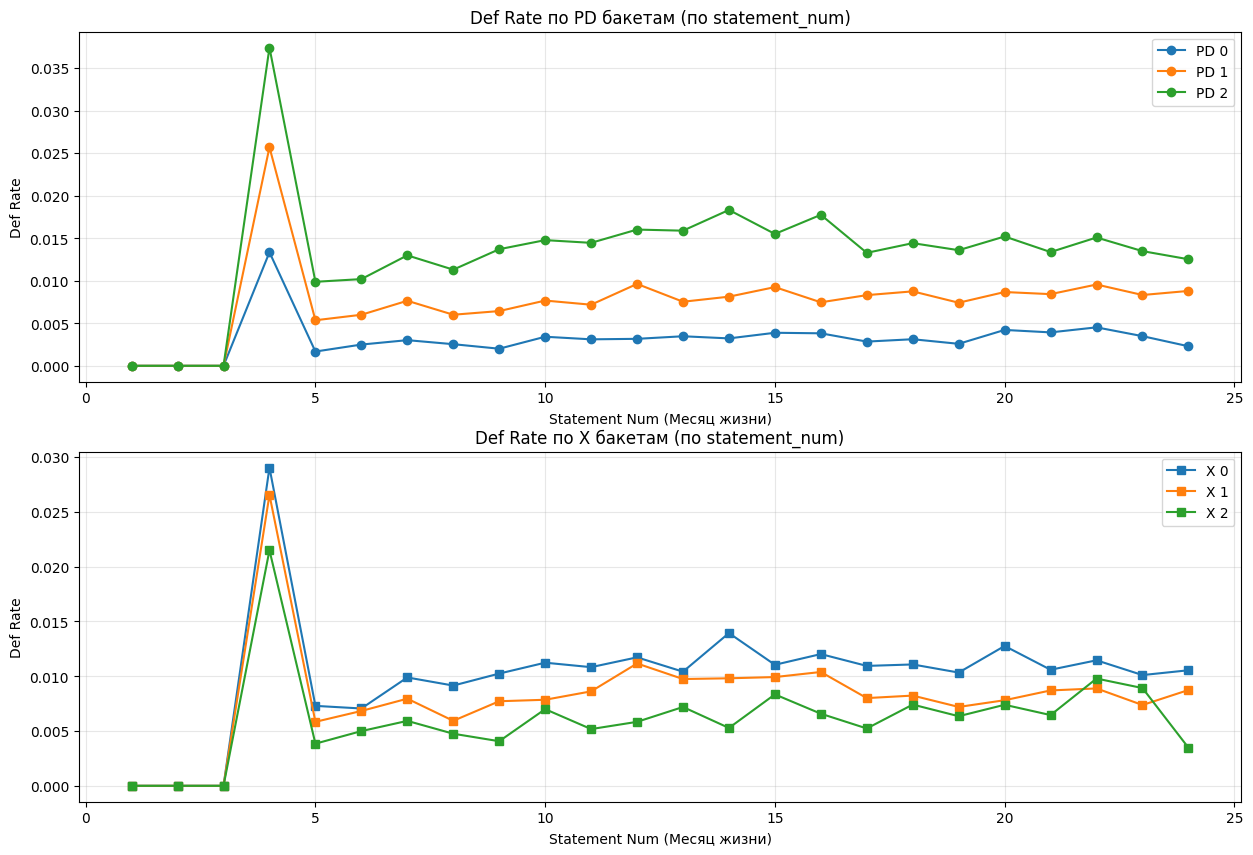

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_def_rate_by_bucket(df, vintage, buckets_pd, buckets_x):
    df = df.copy()

    df["pd_bucket"] = buckets_pd
    df["x_bucket"] = buckets_x
    # для каждого бакета из переменной посчитать def rate начиная с 4 месяца 
    
    merged_df = pd.merge(df, vintage, on='user_id', how='inner')
    merged_df['new_default'] = (merged_df['def_flg'] == 1) & (merged_df['prev_def_flg'] == 0)

    def_cnt_x = (
        merged_df
        .loc[merged_df['new_default'] == 1]
        .groupby(['x_bucket', 'statement_num', ])['user_id']
        .nunique()
    )

    act_prev_cnt_x = (
    merged_df
    .loc[merged_df['prev_act_flg'] == 1]
    .groupby(['x_bucket', 'statement_num'])['user_id']
    .nunique()
    )
    
    def_rate_x = def_cnt_x / act_prev_cnt_x

    def_rate_x = def_rate_x.reset_index(name='def_rate')

    def_cnt_pd = (
        merged_df
        .loc[merged_df['new_default'] == 1]
        .groupby(['pd_bucket', 'statement_num'])['user_id']
        .nunique()
    )

    act_prev_cnt_pd = (
    merged_df
    .loc[merged_df['prev_act_flg'] == 1]
    .groupby(['pd_bucket', 'statement_num'])['user_id']
    .nunique()
    )
    
    def_rate_pd = def_cnt_pd / act_prev_cnt_pd
    def_rate_pd = def_rate_pd.reset_index(name='def_rate')

    def_rate_pd.loc[def_rate_pd['statement_num'] < 4, 'def_rate'] = 0
    def_rate_x.loc[def_rate_x['statement_num'] < 4, 'def_rate'] = 0

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    for bucket in def_rate_pd['pd_bucket'].unique():
        bucket_data = def_rate_pd[def_rate_pd['pd_bucket'] == bucket]
        aggregated = bucket_data.groupby('statement_num')['def_rate'].mean().reset_index()
        axes[0].plot(
            aggregated['statement_num'], 
            aggregated['def_rate'], 
            marker='o', 
            label=f'PD {bucket}'
        )
    axes[0].set_xlabel('Statement Num (Месяц жизни)')
    axes[0].set_ylabel('Def Rate')
    axes[0].set_title('Def Rate по PD бакетам (по statement_num)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2.1 X бакеты - линиями (по statement_num)
    if not def_rate_x.empty:
        for bucket in def_rate_x['x_bucket'].unique():
            bucket_data = def_rate_x[def_rate_x['x_bucket'] == bucket]
            aggregated = bucket_data.groupby('statement_num')['def_rate'].mean().reset_index()
            axes[1].plot(
                aggregated['statement_num'], 
                aggregated['def_rate'], 
                marker='s', 
                label=f'X {bucket}'
            )
        axes[1].set_xlabel('Statement Num (Месяц жизни)')
        axes[1].set_ylabel('Def Rate')
        axes[1].set_title('Def Rate по X бакетам (по statement_num)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

plot_def_rate_by_bucket(data_scores, vintages, buckets_pd, buckets_x)

#### Вывод: Тут очевидно, что PD лучше разделяет по бакетам, ломаные дальше друг от друга

### Анализ поколений (0.5 баллов)

Отрисуй распределение данных во времени в разбивке по выбранной перменной

In [8]:
def plot_distribution(df, vintage, buckets):
    df = df.copy()
    df["bucket"] = buckets
    
    merged_df = pd.merge(df, vintage, on='user_id', how='inner')
    
    
    distribution = (
        merged_df
        .groupby(['gen_month_dt', 'bucket'])['user_id']
        .nunique()
        .reset_index()
        .rename(columns={'user_id': 'count'})
    )
    
    unique_buckets = sorted(distribution['bucket'].unique())
    unique_vintages = sorted(distribution['gen_month_dt'].unique())
    
    plt.figure(figsize=(16, 10))
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_buckets)))
    
    bar_width = 0.7
    

    x_positions = np.arange(len(unique_vintages))
    

    pivot_data = distribution.pivot(
        index='gen_month_dt', 
        columns='bucket', 
        values='count'
    ).fillna(0)

    bottom_values = np.zeros(len(unique_vintages))
    
    for i, bucket in enumerate(unique_buckets):
        
        values = pivot_data[bucket].values
        
        plt.bar(
            x_positions,
            values,
            bottom=bottom_values,  
            width=bar_width,
            color=colors[i],
            edgecolor='white',
            linewidth=1,
            alpha=0.8,
            label=f'Bucket {bucket}'
        )
        
        bottom_values += values  
    
    plt.xlabel('Месяц генерации', fontsize=14)
    plt.ylabel('Количество наблюдений', fontsize=14)
    plt.title('Накопленное распределение по бакетам PD', fontsize=16, fontweight='bold')
    

    plt.xticks(
        x_positions,
        [str(date)[:7] for date in unique_vintages],
        rotation=45,
        ha='right',
        fontsize=11
    )
    

    plt.legend(title='PD Бакеты', fontsize=11, title_fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    plt.tight_layout()
    plt.show()

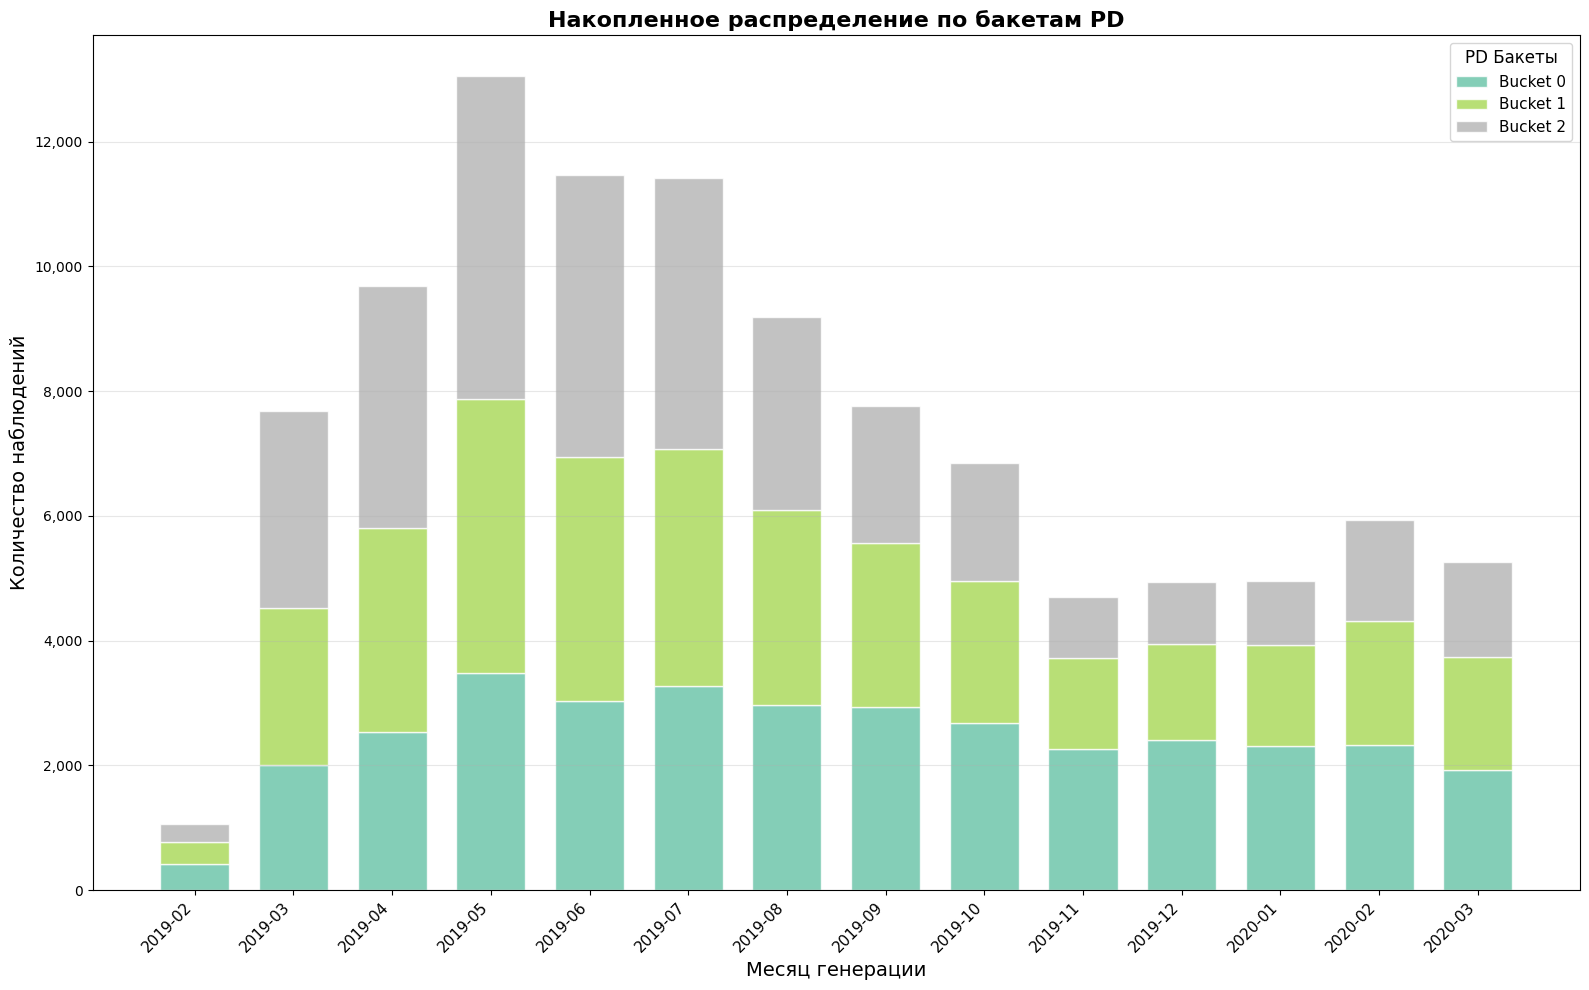

In [9]:
plot_distribution(data_scores, vintages, buckets_pd)

#### Вывод: сделай выводы по полученным графикам. Нужно ли исключать какие-то бакеты/поколения? Если да, то реализуй их исключение из выборки. 
В феврале 2019 года мало наблюдений - исключим

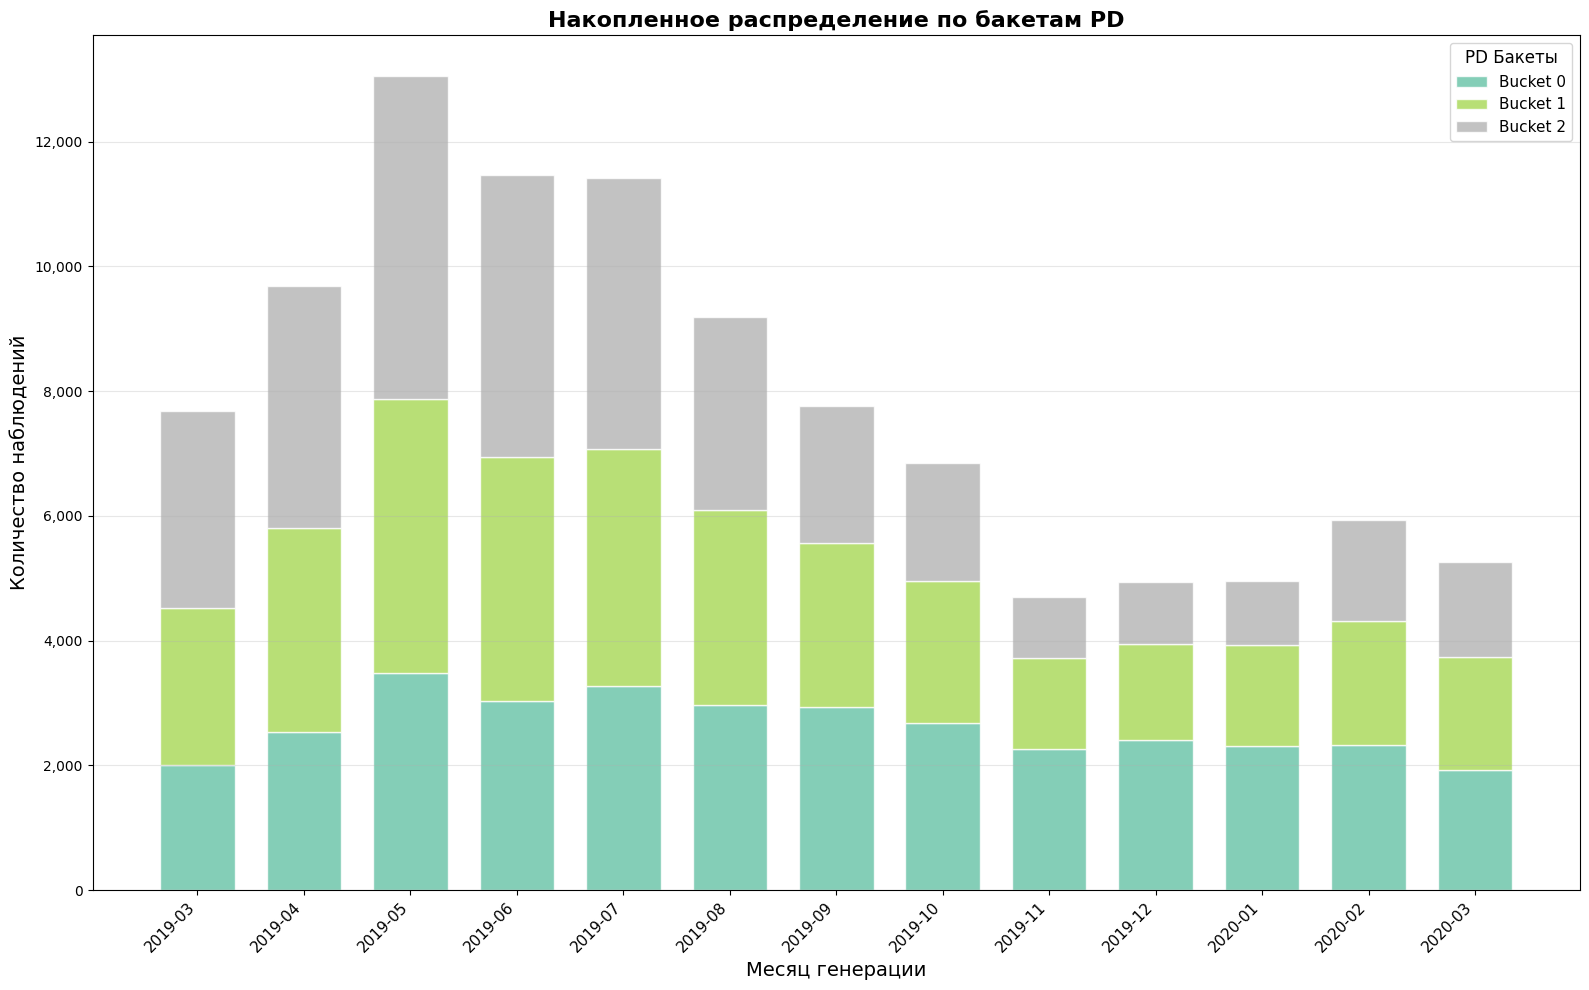

In [10]:
exclude_gens = ['2019-02-01']
vintages_filtered = vintages[~vintages['gen_month_dt'].isin(exclude_gens)]

plot_distribution(data_scores, vintages_filtered, buckets_pd)

### Кривые DEF Rate в разбивке по бакетам (0.5 баллов)

Реализуй функцию, которая отрисовывает винтажи DEF rate в разбивке по бакетам

In [11]:
def plot_def_rate_by_generation(df, vintage, buckets):
#     код функции

    df = df.copy()

    df["bucket"] = buckets
    
    merged_df = pd.merge(df, vintage, on='user_id', how='inner')
    merged_df['new_default'] = (merged_df['def_flg'] == 1) & (merged_df['prev_def_flg'] == 0)

    def_cnt = (
        merged_df
        .loc[merged_df['new_default'] == 1]
        .groupby(['gen_month_dt', 'statement_num', 'bucket'])['user_id']
        .nunique()
    )

    act_prev_cnt = (
    merged_df
    .loc[merged_df['prev_act_flg'] == 1]
    .groupby(['gen_month_dt', 'statement_num', 'bucket'])['user_id']
    .nunique()
    )
    
    def_rate = (def_cnt / act_prev_cnt).reset_index(name='def_rate')
    def_rate.loc[def_rate['statement_num'] < 4, 'def_rate'] = 0
    
    unique_vintages = sorted(def_rate['gen_month_dt'].unique())
    unique_buckets = sorted(def_rate['bucket'].unique())
    
    
    for bucket in unique_buckets:
        plt.figure(figsize=(12, 6))
        
        bucket_data = def_rate[def_rate['bucket'] == bucket]
        
        for gen_date in unique_vintages:
            vintage_data = bucket_data[bucket_data['gen_month_dt'] == gen_date]
            vintage_data = vintage_data.sort_values('statement_num')
            
            plt.plot(
                vintage_data['statement_num'], 
                vintage_data['def_rate'],
                marker='o',
                markersize=4,
                linewidth=1.5,
                label=str(gen_date)
            )
    
        plt.xlabel('Statement Num (Месяц жизни)', fontsize=12)
        plt.ylabel('Default Rate (%)', fontsize=12)
        plt.title(f'Винтажные дефолт-рейты — Bucket {bucket}', fontsize=14, fontweight='bold')
        
        # Форматирование процентов
        from matplotlib.ticker import PercentFormatter
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
        
        plt.xticks(range(1, 25, 2))
        plt.xlim(0.5, 24.5)
        plt.ylim(bottom=0)
        plt.grid(True, alpha=0.3, linestyle='--')
        
        plt.legend(title='Поколение',loc='upper left', fontsize=9)
        plt.tight_layout()
        plt.show()



In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter

def plot_def_rate_by_generation(df, vintage, buckets):
    df = df.copy()
    df["bucket"] = buckets
    
    # Объединение с vintage по user_id
    merged_df = pd.merge(df, vintage, on='user_id', how='inner')
    
    # Определение новых дефолтов
    merged_df['new_default'] = (merged_df['def_flg'] == 1) & (merged_df['prev_def_flg'] == 0)
    
    # Считаем количество дефолтов и активных пользователей
    def_cnt = (
        merged_df
        .loc[merged_df['new_default'] == 1]
        .groupby(['gen_month_dt', 'statement_num', 'bucket'])['user_id']
        .nunique()
    )
    
    act_prev_cnt = (
        merged_df
        .loc[merged_df['prev_act_flg'] == 1]
        .groupby(['gen_month_dt', 'statement_num', 'bucket'])['user_id']
        .nunique()
    )
    
    # Рассчитываем дефолт-рейты
    def_rate = (def_cnt / act_prev_cnt).reset_index(name='def_rate')
    
    # Убираем пропуски (если нужно, можно заменить их на 0)
    def_rate = def_rate.fillna(0)
    
    # Для данных с маленьким statement_num заменяем дефолт-рейты на 0
    def_rate.loc[def_rate['statement_num'] < 4, 'def_rate'] = 0
    
    unique_vintages = sorted(def_rate['gen_month_dt'].unique())
    unique_buckets = sorted(def_rate['bucket'].unique())
    
    # Строим графики для каждого бакета
    for bucket in unique_buckets:
        plt.figure(figsize=(12, 6))
        
        # Фильтруем данные по текущему бакету
        bucket_data = def_rate[def_rate['bucket'] == bucket]
        
        # Используем pivot_table, чтобы преобразовать данные и избежать пропусков
        bucket_data_pivot = bucket_data.pivot_table(
            index='statement_num', 
            columns='gen_month_dt', 
            values='def_rate', 
            fill_value=0  # Заполняем отсутствующие значения нулями
        )
        
        # Строим график для каждого поколения
        bucket_data_pivot.plot(ax=plt.gca(), figsize=(12, 6), lw=2, marker='o')
        
        # Добавляем среднее значение (если нужно)
        # dlq_ratio_mean.loc[bucket, "Среднее"].plot(
        #     figsize=(12, 6), grid=True, lw=3, color="Black", ls="dashed"
        # )
        
        plt.xlabel('Statement Num (Месяц жизни)', fontsize=12)
        plt.ylabel('Default Rate (%)', fontsize=12)
        plt.title(f'Винтажные дефолт-рейты — Bucket {bucket}', fontsize=14, fontweight='bold')
        
        # Форматирование процентов
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
        
        # Настроим отображение оси X
        plt.xticks(range(1, 25, 2))
        plt.xlim(0.5, 24.5)
        plt.ylim(bottom=0)
        
        # Настроим сетку
        plt.grid(True, alpha=0.3, linestyle='--')
        
        # Легенда
        plt.legend(title='Поколение', loc='upper left', fontsize=9)
        
        # Покажем график
        plt.tight_layout()
        plt.show()


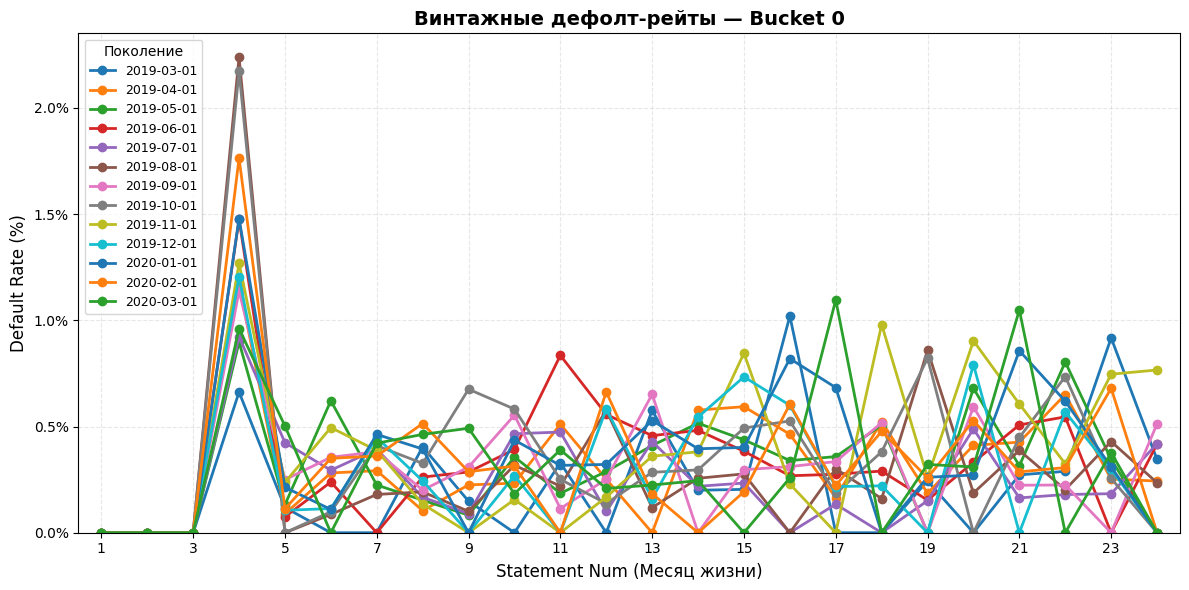

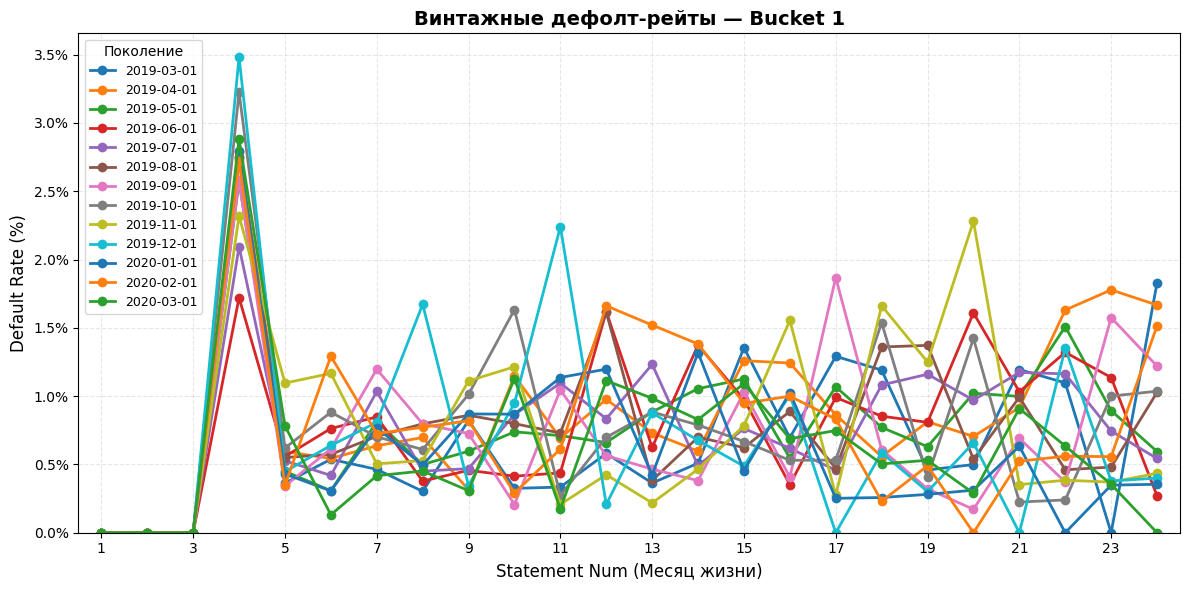

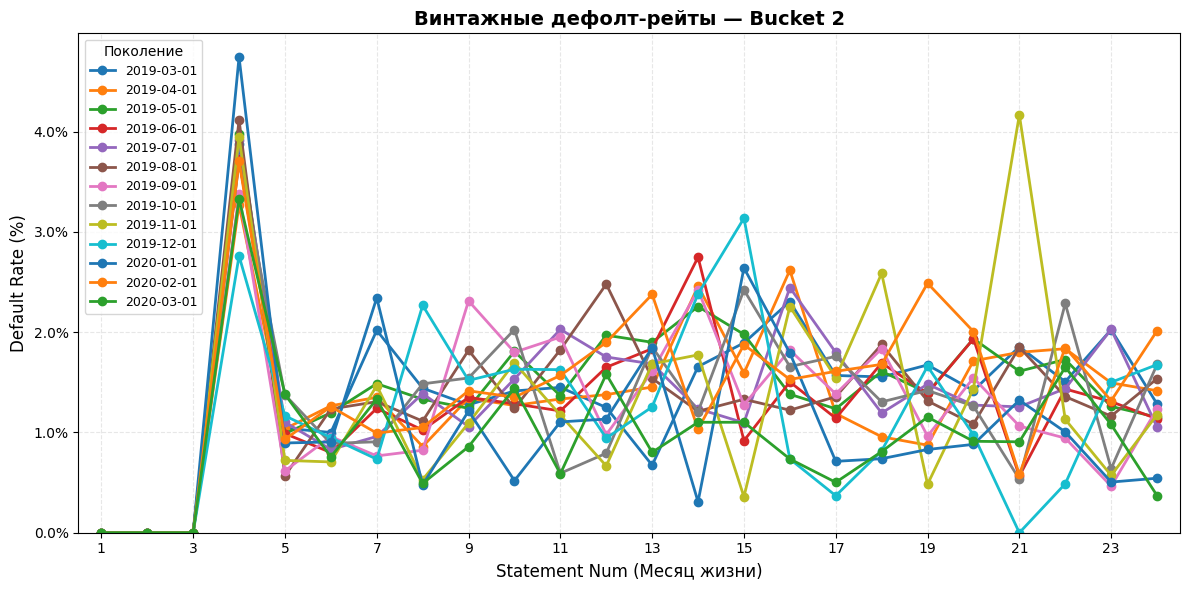

In [13]:
plot_def_rate_by_generation(data_scores, vintages_filtered, buckets_pd)

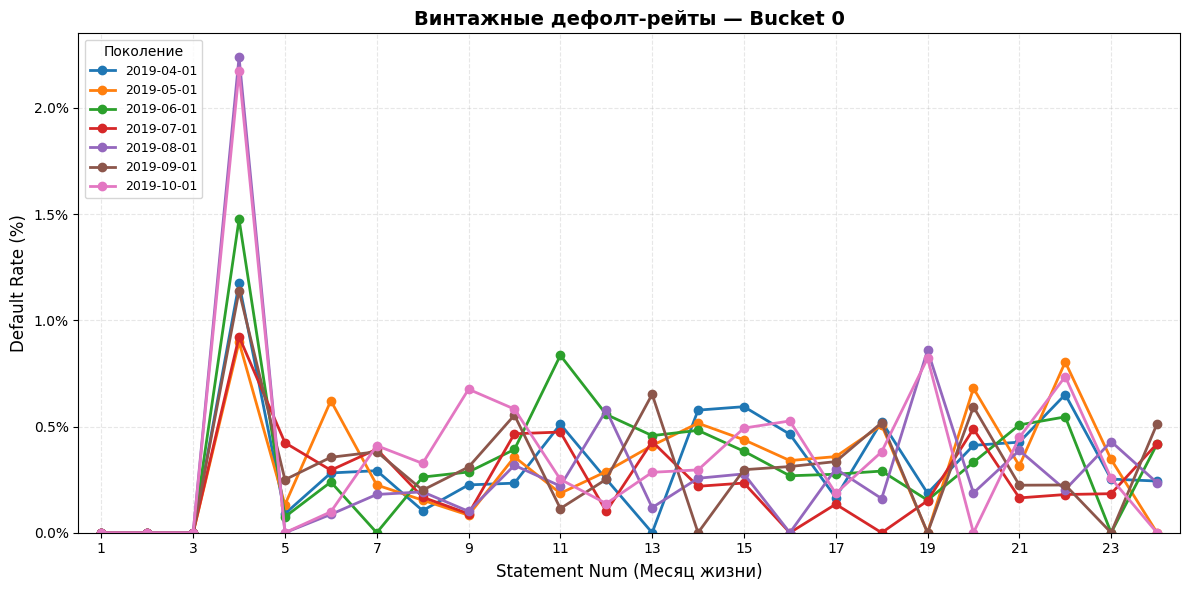

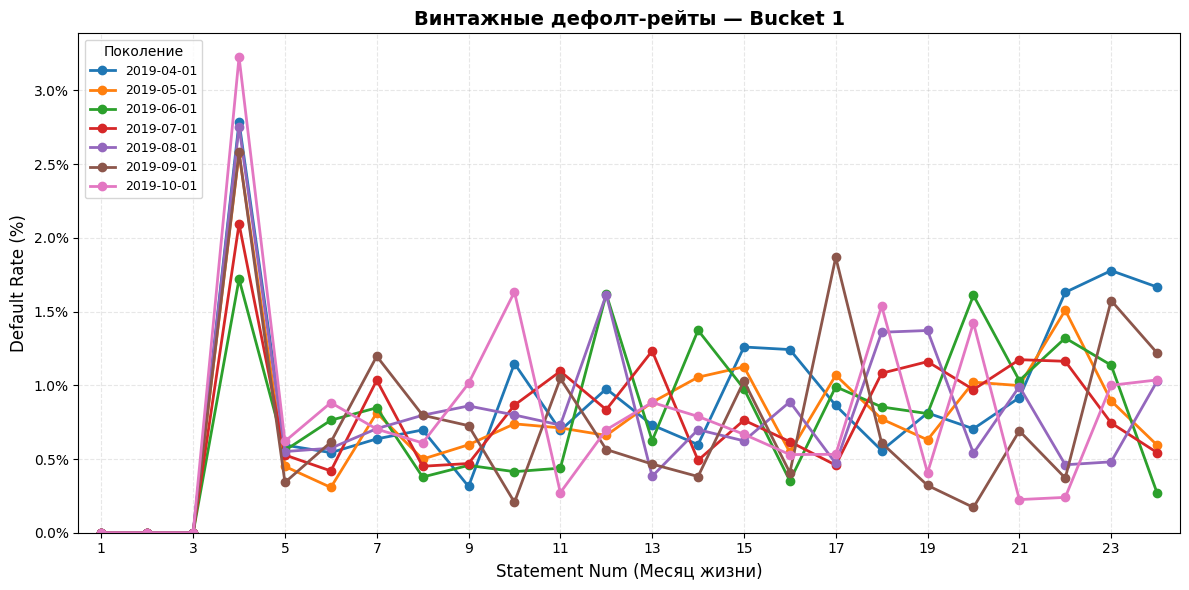

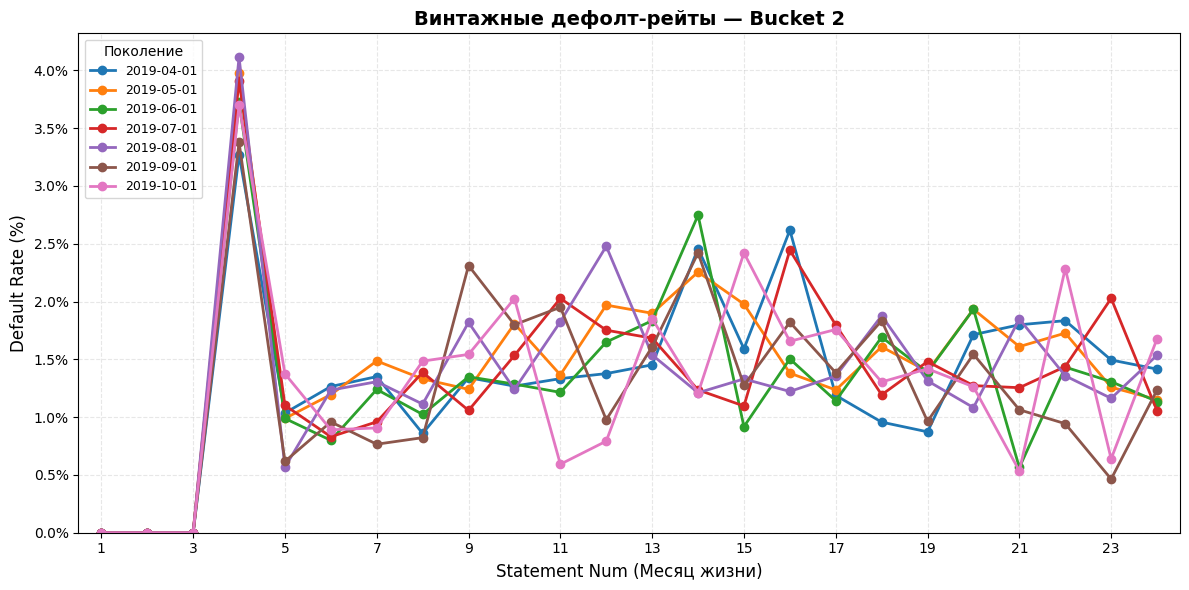

In [14]:
exclude_gens = ['2019-02-01', '2019-03-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2019-11-01']
vintages_filtered = vintages[~vintages['gen_month_dt'].isin(exclude_gens)]

plot_def_rate_by_generation(data_scores, vintages_filtered, buckets_pd)

#### Выводы: сделай выводы по полученным графикам

### Особые точки (0.5 баллов) 
#### Есть ли в винтажах особые точки? Укажи их. Какова их природа? Нужно ли их исключать?

точка 4 - фродовый пик(не трогаем)

особые точки в 20 -21 месяце жизни  в ген 2019-11 просто выброс - исключаем


### Макроэкономические воздействие (2 балла)

/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_64430/2683755010.py:25: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  pd.to_datetime(def_rate['gen_month_dt']) +


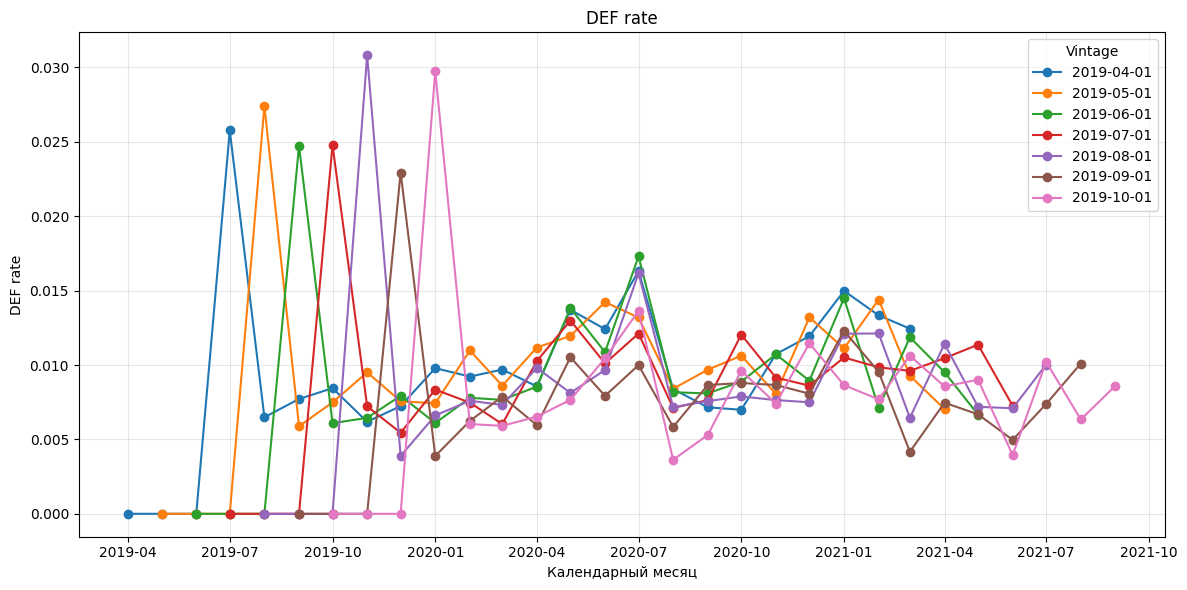

In [15]:
def plot_def_Chrono(df, vintage):
    df = df.copy()
    
    merged_df = pd.merge(df, vintage, on='user_id', how='inner')
    merged_df['new_default'] = (merged_df['def_flg'] == 1) & (merged_df['prev_def_flg'] == 0)

    def_cnt = (
        merged_df
        .loc[merged_df['new_default'] == 1]
        .groupby(['gen_month_dt', 'statement_num'])['user_id']
        .nunique()
    )

    act_prev_cnt = (
    merged_df
    .loc[merged_df['prev_act_flg'] == 1]
    .groupby(['gen_month_dt', 'statement_num'])['user_id']
    .nunique()
    )
    
    def_rate = (def_cnt / act_prev_cnt).reset_index(name='def_rate')
    def_rate.loc[def_rate['statement_num'] < 4, 'def_rate'] = 0
    
    def_rate['calendar_month'] = (
        pd.to_datetime(def_rate['gen_month_dt']) +
        def_rate['statement_num'].sub(1).apply(lambda x: pd.DateOffset(months=x))
    )

    def_rate = def_rate.sort_values(['gen_month_dt', 'calendar_month'])


    plt.figure(figsize=(12, 6))

    for gen_month in sorted(def_rate['gen_month_dt'].unique()):
        tmp = def_rate[def_rate['gen_month_dt'] == gen_month]
        plt.plot(
            tmp['calendar_month'],
            tmp['def_rate'],
            marker='o',
            label=str(gen_month)
        )

    plt.title('DEF rate')
    plt.xlabel('Календарный месяц')
    plt.ylabel('DEF rate')
    plt.legend(title='Vintage', loc='best')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_def_Chrono(data_scores, vintages_filtered)

#### Есть ли в винтажах DEF rate макроэкономическое воздействие (нарисуй график иллюстрирующее это воздействие)? Если да, то предположи какое событие его вызвало и почему?
#### В случае наличия внешнего влияния 
#### 1) Разложи кривые на внешнее воздействие и созревание кривых
#### 2) Отрисуй график внешнего воздествия
#### 3) Отрисуй вычищенные винтажи DEF rate в разбивке по бакетам
#### 4) Посчитай среднее для этих бакетов и реализуй сглаживание

ЛОКДАУН ЛЕТО 2020

## def rate редкая дискретная вероятность, сколько не пытался докрутить метод с семинара, не вышло. 

In [16]:
from scipy.optimize import minimize
from sklearn.metrics import r2_score

def curve_build(data, feature, generation="generation_quart",
                statement_num="statement_num", group_label="1", stable_from=6):

    df_query = data.sort_values([generation, statement_num]).reset_index(drop=True)

    generation_min = df_query[generation].min()

    values = df_query[feature].to_numpy(dtype=float)
    st_nums = (df_query[statement_num].to_numpy(dtype=int) - 1)   # возраст a=0..A-1

    # календарный индекс t=0..T-1 для каждой строки
    dates = (
        df_query[generation].dt.year * 12 + df_query[generation].dt.month
        - (generation_min.year * 12 + generation_min.month)
        + df_query[statement_num].to_numpy(dtype=int) - 1
    ).to_numpy(dtype=int)

    A = int(st_nums.max() + 1)          # длина M(a)
    T = int(dates.max() + 1)            # длина E(t)
    tab_size = len(df_query)

    stable_mask = (np.arange(T) >= stable_from)  # t>=6

    def unpack_x(x):
        E_raw = x[:T]
        M_raw = x[T:T+A]

        # среднее только по "стабильному" окну
        if stable_mask.any():
            mean_E = E_raw[stable_mask].mean()
        else:
            mean_E = E_raw.mean()

        if mean_E == 0:
            mean_E = 1e-12

        # теперь mean(E[stable_mask]) == 1
        E = E_raw / mean_E

        # сохраняем инвариантность произведения E*M
        M = M_raw * mean_E
        return E, M

    def r_square(x):
        E, M = unpack_x(x)
        pred = E[dates] * M[st_nums]
        return np.sum((values - pred) ** 2)

    x0 = np.ones(T + A, dtype=float)

    res0 = minimize(
        r_square,
        x0,
        tol=1e-6,
        method="Powell",
        options={"disp": False, "maxiter": 1000},
    )

    # достаем уже нормированные E и M
    E_hat, M_hat = unpack_x(res0.x)

    external_data = pd.DataFrame({
        "month_dt": [generation_min + pd.DateOffset(months=i) for i in range(T)],
        group_label: E_hat
    })

    maturation_data = pd.DataFrame({
        "statement_num": np.arange(1, A + 1),
        group_label: M_hat
    })

    # fitted: D / E (если хотите "очистить" от макро)
    df_query = df_query.copy()
    df_query["month_dt"] = pd.to_datetime(df_query["month_dt"], errors="coerce")
    external_data["month_dt"] = pd.to_datetime(external_data["month_dt"], errors="coerce")

    df_fitted = df_query.merge(external_data, on="month_dt", how="left")
    df_fitted["fitted_feature"] = df_fitted[feature] / df_fitted[group_label]

    return {
        "res0": res0,
        "external_data": external_data,
        "maturation_data": maturation_data,
        "df_fitted": df_fitted,
    }

def decomposition(
    df,
    generation="generation_month",
    group="bucket",
    statement_num="statement_num",
    feature="feature",
    optimization_query="",
):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == "":
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
    df_query["month_dt"] = df_query[generation] + timedelta

    # Формируем список бакетов

    df_query.sort_values(by=[group], inplace=True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + " = " + str(g))

        # Строим разложение для одного бакета
        res = curve_build(
            df_temp,
            feature=feature,
            generation=generation,
            statement_num=statement_num,
            group_label=str(g),
        )
        df_fitted_temp = pd.DataFrame(res["df_fitted"])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res["external_data"])[["month_dt", str(g)]]
            maturation_data = pd.DataFrame(res["maturation_data"])[
                [statement_num, str(g)]
            ]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(
                right=res["external_data"], on=["month_dt"]
            )
            maturation_data = maturation_data.merge(
                right=res["maturation_data"], on=[statement_num]
            )
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i += 1

    # print(res)

    res_multiple = {
        "external_data": external_data,
        "maturation_data": maturation_data,
        "fitted_data": df_fitted,
    }
    return res_multiple

In [17]:
data_scores["pd_bucket"] = buckets_pd
    
merged_df = pd.merge(data_scores, vintages, on='user_id', how='inner')
merged_df['new_default'] = (merged_df['def_flg'] == 1) & (merged_df['prev_def_flg'] == 0)
merged_df['gen_month_dt'] = pd.to_datetime(merged_df['gen_month_dt'])

def_cnt = (
    merged_df
    .loc[merged_df['new_default'] == 1]
    .groupby(['gen_month_dt', 'statement_num', 'pd_bucket'])['user_id']
    .nunique()
)

act_prev_cnt = (
merged_df
.loc[merged_df['prev_act_flg'] == 1]
.groupby(['gen_month_dt', 'statement_num', 'pd_bucket'])['user_id']
.nunique()
)

# Сбросим индекс для деления
def_cnt_df = def_cnt.reset_index(name='def_cnt')
act_prev_cnt_df = act_prev_cnt.reset_index(name='act_prev_cnt')

def_rate = pd.merge(
    act_prev_cnt_df, def_cnt_df,
    on=['gen_month_dt', 'statement_num', 'pd_bucket'],
    how='left'
)

def_rate['def_cnt'] = def_rate['def_cnt'].fillna(0)
def_rate['def_rate'] = def_rate['def_cnt'] / def_rate['act_prev_cnt']

# Применяем правило для statement_num < 4
def_rate.loc[def_rate['statement_num'] < 4, 'def_rate'] = 0

def_rate_opt = def_rate.query("statement_num >= 4").copy()


# Счетчик итераций
Nfeval = 0
# Проводим разложение кривых



res = decomposition(
    def_rate_opt,
    generation="gen_month_dt",
    group="pd_bucket",
    statement_num="statement_num",
    feature="def_rate",
)


/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_64430/2825350726.py:125: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query["month_dt"] = df_query[generation] + timedelta


pd_bucket = 0
pd_bucket = 1
pd_bucket = 2


In [18]:
print(res['external_data'].head())
print(res['external_data'].isna().sum())

    month_dt           0           1          2
0 2019-02-01  234.388353  115.988273  68.826653
1 2019-03-01  234.388353  115.988273  68.826653
2 2019-04-01  234.388353  115.988273  68.826653
3 2019-05-01    0.821797    0.735865   0.629335
4 2019-06-01    0.468607    1.123275   1.189662
month_dt    0
0           0
1           0
2           0
dtype: int64


In [19]:
# Проверяем, что действительно нормировали внешку
stable_from = 6

E = res['external_data'][['0', '1', '2']].to_numpy()
t = np.arange(len(E))
mask = t >= stable_from

mean_stable = E[mask].mean()

print("Mean(E):", mean_stable)


Mean(E): 1.0000000000000002


In [20]:
(def_rate['def_rate'] > 1).mean(), def_rate['def_rate'].max()
def_rate['act_prev_cnt'].describe()

count    1008.000000
mean      809.425595
std       506.103722
min        53.000000
25%       428.500000
50%       716.000000
75%      1086.000000
max      2809.000000
Name: act_prev_cnt, dtype: float64

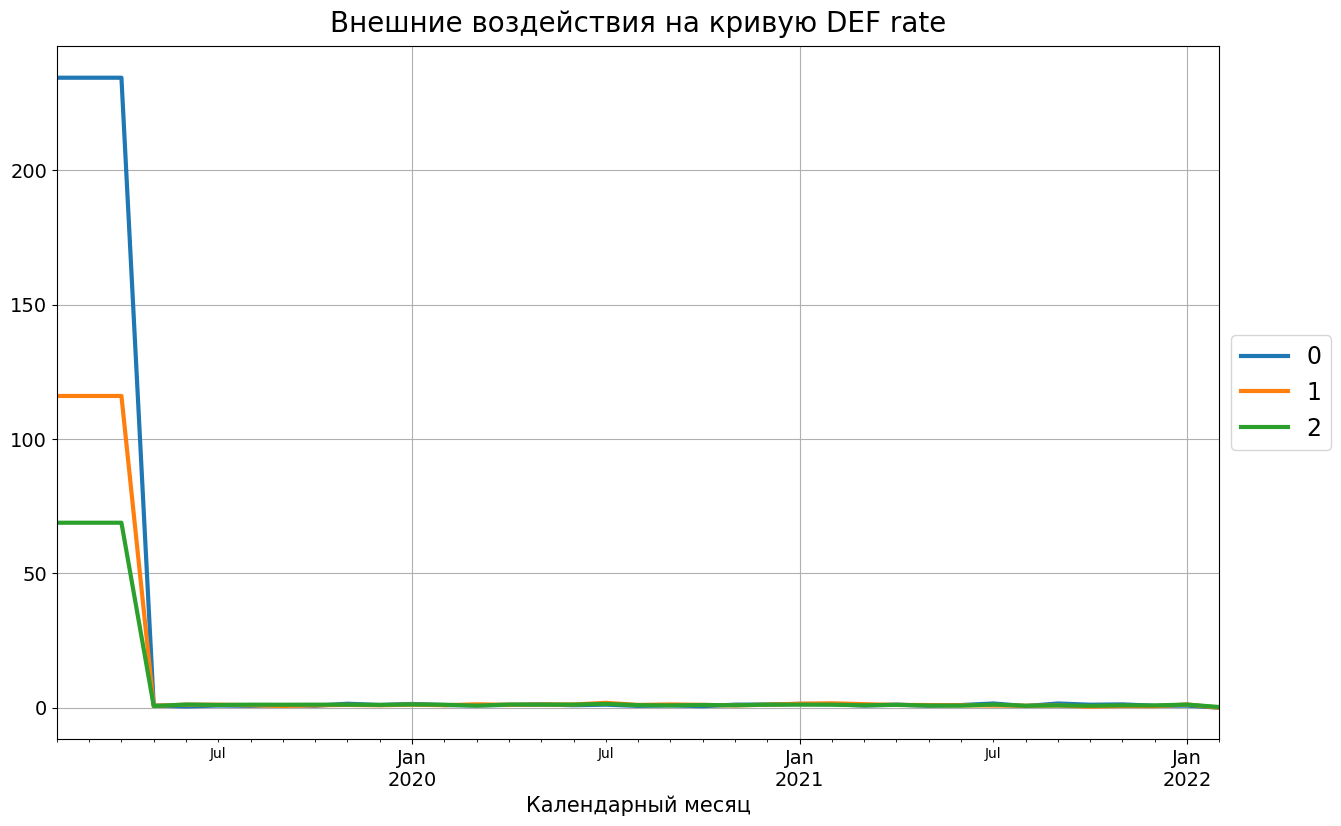

In [21]:
res["external_data"].set_index("month_dt").plot(
    ax=None, figsize=(15, 9), grid=True, lw=3
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title(
    "Внешние воздействия на кривую DEF rate", size=20, verticalalignment="bottom"
)

plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

Binomial + logit с минимизацией правдоподобия:

In [22]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def _sigmoid(z):
    # стабильная сигмоида
    z = np.clip(z, -35, 35)
    return 1.0 / (1.0 + np.exp(-z))

def curve_build_binomial(
    data: pd.DataFrame,
    generation: str,
    statement_num: str,
    def_cnt_col: str,
    exposure_col: str,            # act_prev_cnt
    group_label: str = "1",
    stable_from: int = 6,         # начиная с какого t считаем "стабильное окно" для нормировки
    reg_lambda_t: float = 0.0,    # (опц.) регуляризация гладкости по времени
    reg_lambda_a: float = 0.0,    # (опц.) регуляризация гладкости по возрасту
    eps: float = 1e-12,
):
    """
    Разложение binomial-logit:
        def_cnt ~ Binomial(exposure, p)
        logit(p_{t,a}) = alpha_t + beta_a

    Возвращает:
      external_data: month_dt, alpha, macro_or=exp(alpha)
      maturation_data: statement_num, beta, age_or=exp(beta - beta[0])
      df_fitted: исходные строки + p_hat, alpha, beta, p_no_macro, p_no_age, etc.
    """

    df = data.copy()
    df = df.sort_values([generation, statement_num]).reset_index(drop=True)

    # проверки
    for col in [generation, statement_num, def_cnt_col, exposure_col]:
        if col not in df.columns:
            raise ValueError(f"Нет колонки '{col}' в data")

    # типы
    df[generation] = pd.to_datetime(df[generation], errors="coerce")
    df = df[df[generation].notna()].copy()
    df[statement_num] = df[statement_num].astype(int)

    # базовые массивы
    gen_min = df[generation].min()

    k = df[def_cnt_col].to_numpy(dtype=float)        # def_cnt
    n = df[exposure_col].to_numpy(dtype=float)       # exposure

    # уберём строки без экспозиции или с некорректными значениями
    mask = (n > 0) & (k >= 0) & (k <= n)
    df = df.loc[mask].copy()
    k = k[mask]
    n = n[mask]

    # индексы возраста a = 0..A-1
    a_idx = df[statement_num].to_numpy(dtype=int) - 1
    A = int(a_idx.max() + 1)

    # календарный индекс t = 0..T-1
    # аналогично вашему коду: month index of generation + (statement_num-1)
    gen_month_index = df[generation].dt.year * 12 + df[generation].dt.month
    gen_min_index = gen_min.year * 12 + gen_min.month
    t_idx = (gen_month_index - gen_min_index + (df[statement_num] - 1)).to_numpy(dtype=int)
    T = int(t_idx.max() + 1)

    stable_mask = (np.arange(T) >= stable_from)

    # --- нормировка инвариантности сдвига ---
    # logit(p)=alpha+beta инвариантно к alpha+=c, beta-=c
    # фиксируем mean(alpha[stable])=0: alpha = alpha_raw - m, beta = beta_raw + m
    def unpack_x(x):
        alpha_raw = x[:T]
        beta_raw  = x[T:T+A]

        if stable_mask.any():
            m = alpha_raw[stable_mask].mean()
        else:
            m = alpha_raw.mean()

        alpha = alpha_raw - m
        beta  = beta_raw + m
        return alpha, beta

    def nll(x):
        alpha, beta = unpack_x(x)
        eta = alpha[t_idx] + beta[a_idx]      # линейный предиктор
        p = _sigmoid(eta)
        p = np.clip(p, eps, 1 - eps)

        # отрицательный лог-правдоподобие биномиала (без константы log C(n,k))
        ll = k * np.log(p) + (n - k) * np.log(1 - p)
        loss = -np.sum(ll)

        # (опц.) регуляризация гладкости (вторая разность) чтобы факторы не "пилили" шум
        if reg_lambda_t > 0 and T >= 3:
            d2 = alpha[2:] - 2*alpha[1:-1] + alpha[:-2]
            loss += reg_lambda_t * np.sum(d2**2)
        if reg_lambda_a > 0 and A >= 3:
            d2 = beta[2:] - 2*beta[1:-1] + beta[:-2]
            loss += reg_lambda_a * np.sum(d2**2)

        return loss

    # стартовое приближение: общий logit на базе
    # чтобы не стартовать "в нуле", оценим средний p (с клипом)
    p0 = np.clip(k.sum() / n.sum(), 1e-6, 1 - 1e-6)
    global_logit = np.log(p0 / (1 - p0))

    x0 = np.zeros(T + A, dtype=float)
    # размажем общий уровень по beta (или alpha) — можно так:
    x0[T:T+A] = global_logit

    res = minimize(
        nll,
        x0,
        method="L-BFGS-B",
        options={"maxiter": 2000, "ftol": 1e-9},
    )

    alpha_hat, beta_hat = unpack_x(res.x)

    # month_dt для t=0..T-1
    external_data = pd.DataFrame({
        "month_dt": [gen_min + pd.DateOffset(months=i) for i in range(T)],
        group_label: alpha_hat,
        f"{group_label}_macro_or": np.exp(alpha_hat),   # odds ratio относительно стабильного среднего
    })

    maturation_data = pd.DataFrame({
        statement_num: np.arange(1, A + 1),
        group_label: beta_hat,
        f"{group_label}_age_or": np.exp(beta_hat - beta_hat[0]),  # OR возраста относительно первого возраста
    })

    # fitted
    df_fit = df.copy()
    df_fit["month_dt"] = pd.to_datetime(df_fit[generation]) + df_fit[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))

    # присоединим alpha по month_dt (тут month_dt именно календарный t, не generation)
    # лучше напрямую по t_idx:
    eta_hat = alpha_hat[t_idx] + beta_hat[a_idx]
    p_hat = _sigmoid(eta_hat)

    df_fit["alpha_t"] = alpha_hat[t_idx]
    df_fit["beta_a"] = beta_hat[a_idx]
    df_fit["p_hat"] = p_hat
    df_fit["def_rate_fact"] = df_fit[def_cnt_col] / df_fit[exposure_col]

    # "очистка" от макро: p при alpha=0 (нейтральное макро)
    df_fit["p_no_macro"] = _sigmoid(df_fit["beta_a"])

    # "очистка" от возраста: p при beta=0 (нейтральное созревание)
    df_fit["p_no_age"] = _sigmoid(df_fit["alpha_t"])

    return {
        "res": res,
        "external_data": external_data,
        "maturation_data": maturation_data,
        "df_fitted": df_fit,
    }


def decomposition_binomial(
    df: pd.DataFrame,
    generation: str,
    group: str,
    statement_num: str,
    def_cnt_col: str,
    exposure_col: str,
    optimization_query: str = "",
    stable_from: int = 6,
    reg_lambda_t: float = 0.0,
    reg_lambda_a: float = 0.0,
):
    """
    Цикл по бакетам. Возвращает:
      external_data: month_dt + alpha по каждому бакету (+macro_or)
      maturation_data: statement_num + beta по каждому бакету (+age_or)
      fitted_data: объединённый df_fitted со всеми бакетами
    """

    if optimization_query:
        dfq = df.query(optimization_query).copy()
    else:
        dfq = df.copy()

    dfq[generation] = pd.to_datetime(dfq[generation], errors="coerce")
    dfq = dfq[dfq[generation].notna()].copy()

    groups = pd.Series(dfq[group].drop_duplicates()).tolist()

    external_data = None
    maturation_data = None
    fitted_all = []

    for i, g in enumerate(groups):
        dfg = dfq[dfq[group] == g].copy()
        print(f"{group} = {g}")

        resg = curve_build_binomial(
            dfg,
            generation=generation,
            statement_num=statement_num,
            def_cnt_col=def_cnt_col,
            exposure_col=exposure_col,
            group_label=str(g),
            stable_from=stable_from,
            reg_lambda_t=reg_lambda_t,
            reg_lambda_a=reg_lambda_a,
        )

        ext_g = resg["external_data"][["month_dt", str(g), f"{str(g)}_macro_or"]]
        mat_g = resg["maturation_data"][[statement_num, str(g), f"{str(g)}_age_or"]]
        fit_g = resg["df_fitted"].copy()
        fit_g[group] = g

        if i == 0:
            external_data = ext_g
            maturation_data = mat_g
        else:
            external_data = external_data.merge(ext_g, on="month_dt", how="outer")
            maturation_data = maturation_data.merge(mat_g, on=statement_num, how="outer")

        fitted_all.append(fit_g)

    fitted_data = pd.concat(fitted_all, ignore_index=True)

    return {
        "external_data": external_data.sort_values("month_dt").reset_index(drop=True),
        "maturation_data": maturation_data.sort_values(statement_num).reset_index(drop=True),
        "fitted_data": fitted_data,
    }


In [23]:
def_cnt = (
    merged_df
    .loc[merged_df['new_default'] == 1 ]
    .groupby(['gen_month_dt', 'statement_num', 'pd_bucket'])['user_id']
    .nunique()
    .reset_index(name='def_cnt')
)

act_prev_cnt = (
    merged_df
    .loc[merged_df['prev_act_flg'] == 1]
    .groupby(['gen_month_dt', 'statement_num', 'pd_bucket'])['user_id']
    .nunique()
    .reset_index(name='act_prev_cnt')
)

df_def = act_prev_cnt.merge(def_cnt, on=['gen_month_dt','statement_num','pd_bucket'], how='left')
df_def['def_cnt'] = df_def['def_cnt'].fillna(0).astype(int)
df_def['def_rate'] = df_def['def_cnt'] / df_def['act_prev_cnt']


pd_bucket = 0
pd_bucket = 1
pd_bucket = 2


/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_64430/2187793375.py:140: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_fit["month_dt"] = pd.to_datetime(df_fit[generation]) + df_fit[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_64430/2187793375.py:140: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_fit["month_dt"] = pd.to_datetime(df_fit[generation]) + df_fit[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))
/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_64430/2187793375.py:140: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_fit["month_dt"] = pd.to_datetime(df_fit[generation]) + df_fit[statement_num].apply(lambda x: pd.DateOffset(months=x - 1))


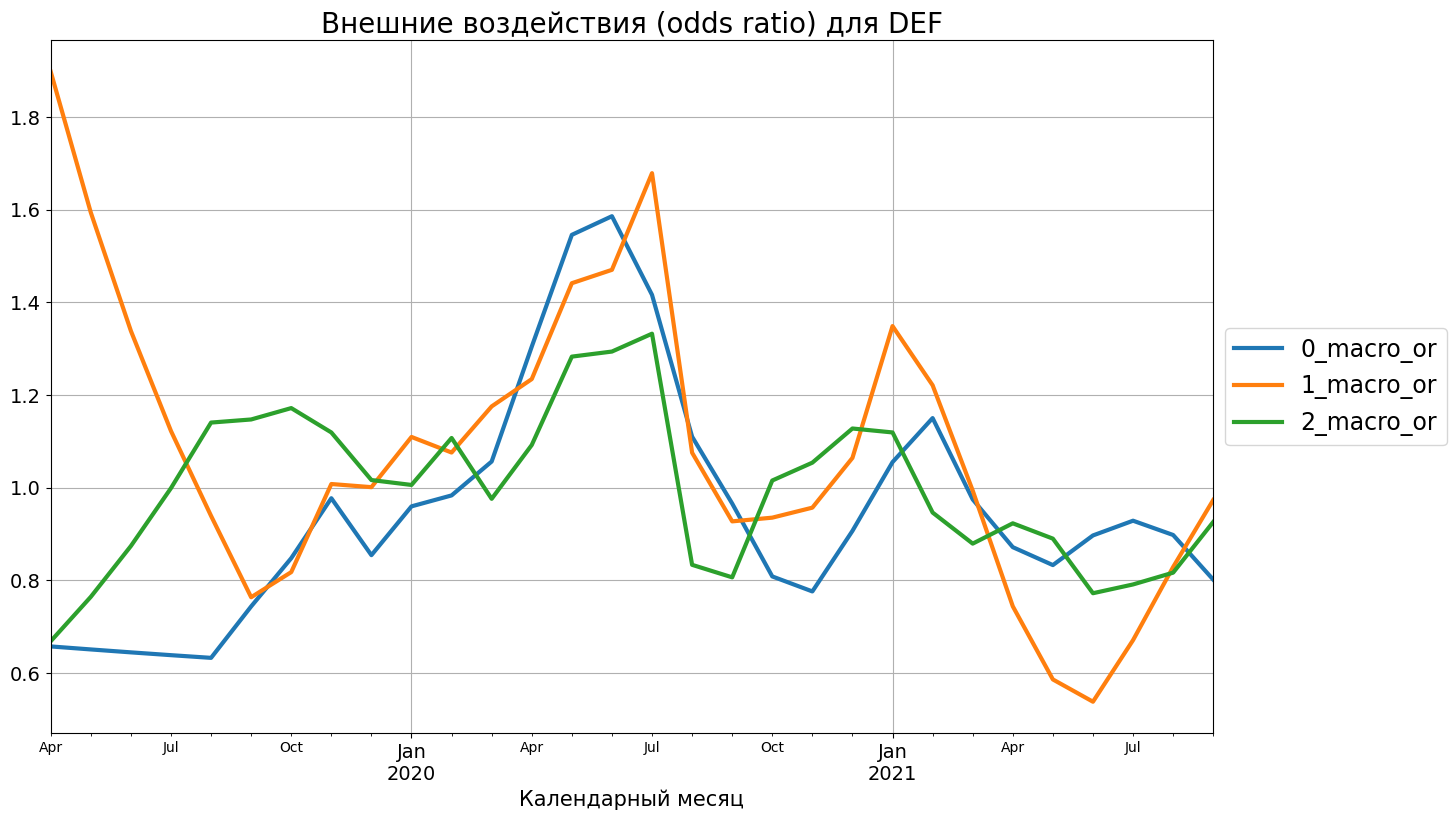

In [24]:
#очистка
exclude_gens = pd.to_datetime([
    '2019-02-01','2019-03-01','2019-12-01',
    '2020-01-01','2020-02-01','2020-03-01', '2019-11-01'
])


df_def_filt = df_def.copy()
df_def_filt["gen_month_dt"] = pd.to_datetime(df_def_filt["gen_month_dt"])

df_def_filt = df_def_filt.loc[~df_def_filt["gen_month_dt"].isin(exclude_gens)]

res_def = decomposition_binomial(
    df_def_filt.query("statement_num >= 4"),
    generation="gen_month_dt",
    group="pd_bucket",
    statement_num="statement_num",
    def_cnt_col="def_cnt",
    exposure_col="act_prev_cnt",
    stable_from=6,
    reg_lambda_t=5.0,
    reg_lambda_a=5.0,
)

ext = res_def["external_data"].set_index("month_dt")
cols = [c for c in ext.columns if c.endswith("_macro_or")]

ax = ext[cols].plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17)
plt.title("Внешние воздействия (odds ratio) для DEF", size=20)
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

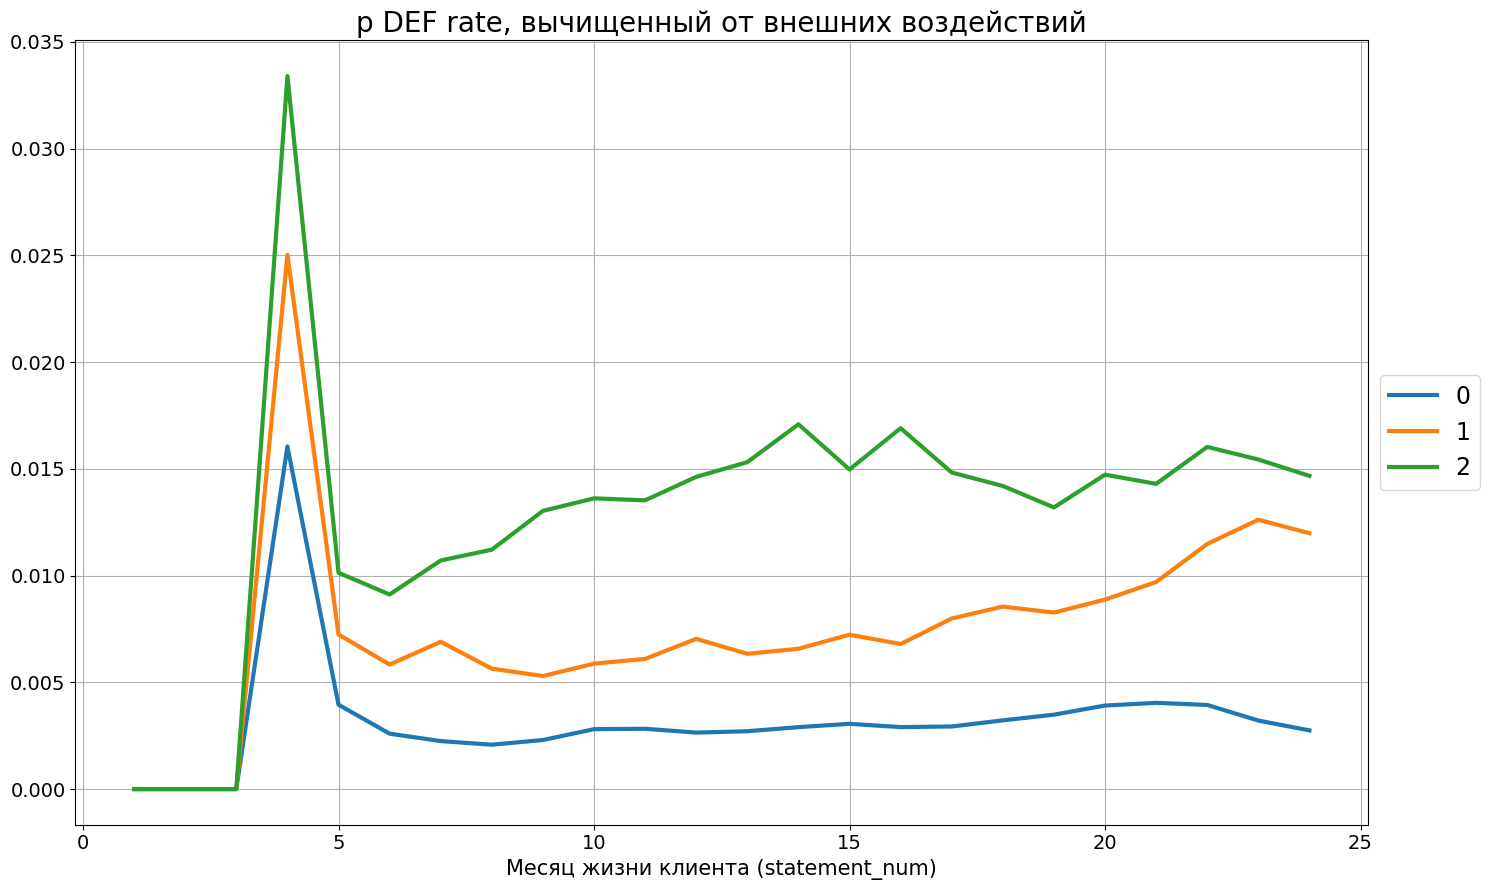

In [25]:
clean = (
    res_def["fitted_data"]
    .groupby(["pd_bucket", "statement_num"], as_index=False)
    .agg(def_clean=("p_no_macro", "mean"))
)

buckets = sorted(clean["pd_bucket"].unique())
pad = pd.DataFrame(
    [(b, s, 0.0) for b in buckets for s in [1, 2, 3]],
    columns=["pd_bucket", "statement_num", "def_clean"]
)

clean2 = (
    pd.concat([pad, clean], ignore_index=True)
      .sort_values(["pd_bucket", "statement_num"])
)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 9))
for b, d in clean2.groupby("pd_bucket"):
    plt.plot(d["statement_num"], d["def_clean"], lw=3, label=str(b))

plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=17)
plt.title("p DEF rate, вычищенный от внешних воздействий", size=20)
plt.xlabel("Месяц жизни клиента (statement_num)", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tight_layout()
plt.show()

### Среднее по бакетам (0.5 баллов) 
Выбери один из способой нахождение средней кривой (возможные способы указаны в лекции). Обоснуй свой выбор.

Реализуй функцию построения среднего.

средняя кривая (как оценка вероятности), полученная из биномиального разложения, очищенная от внешнего воздействия. Она не шумит как def_rate. 

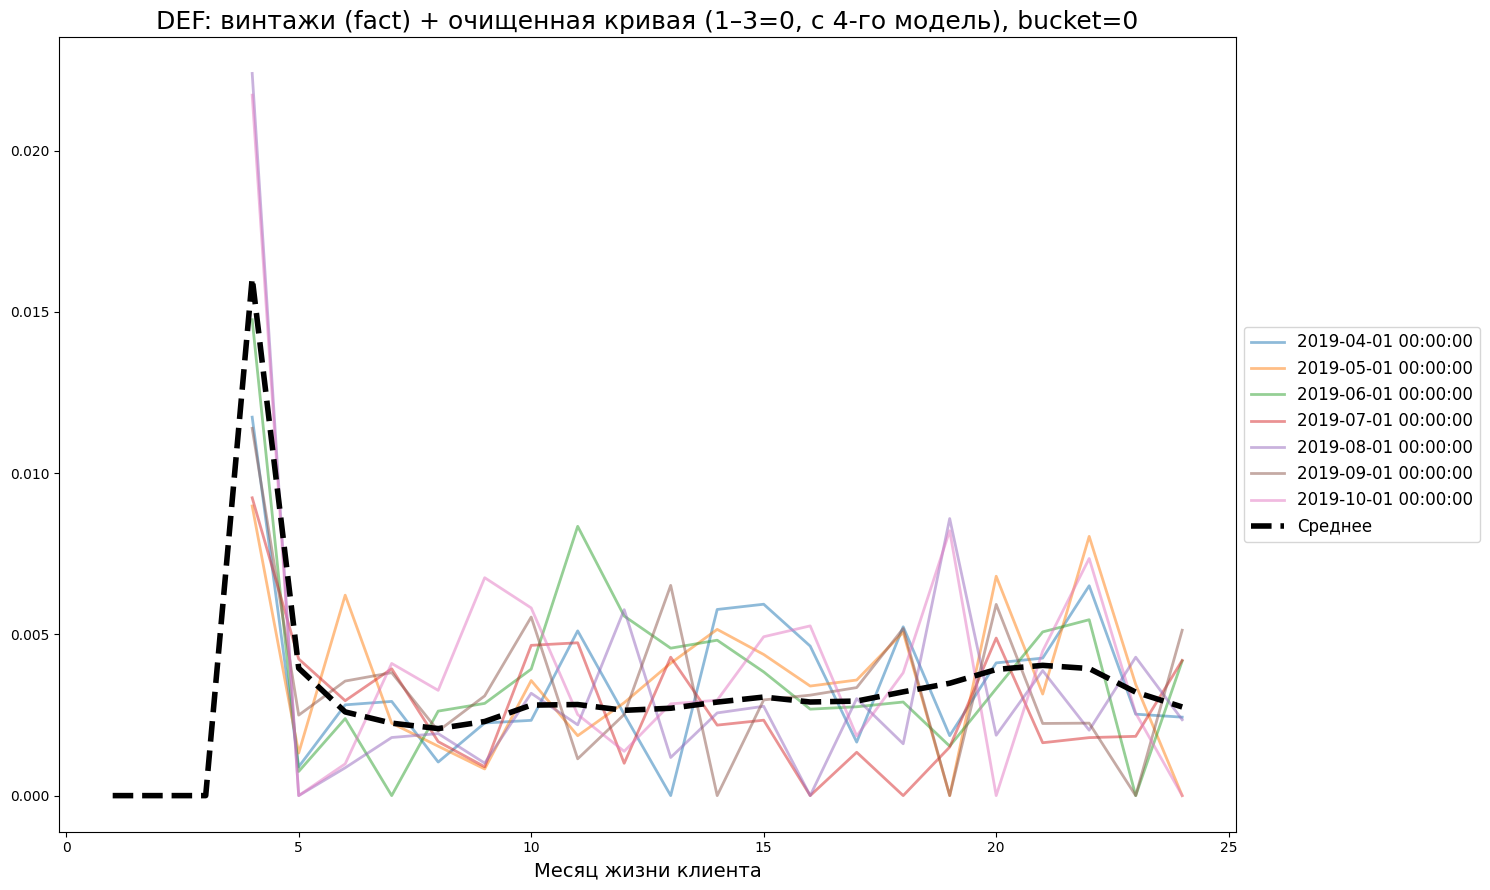

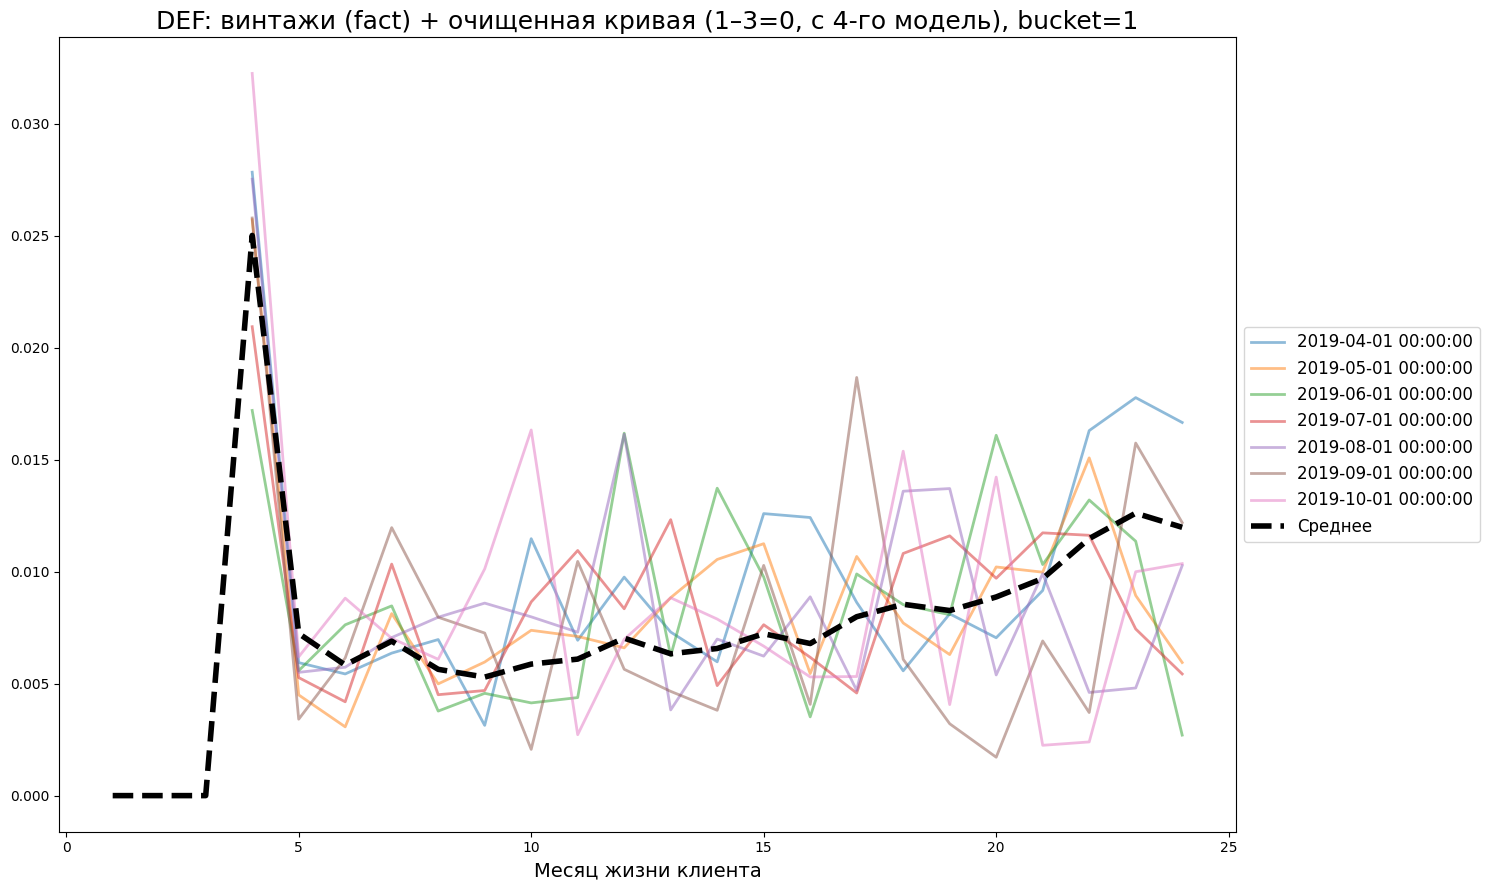

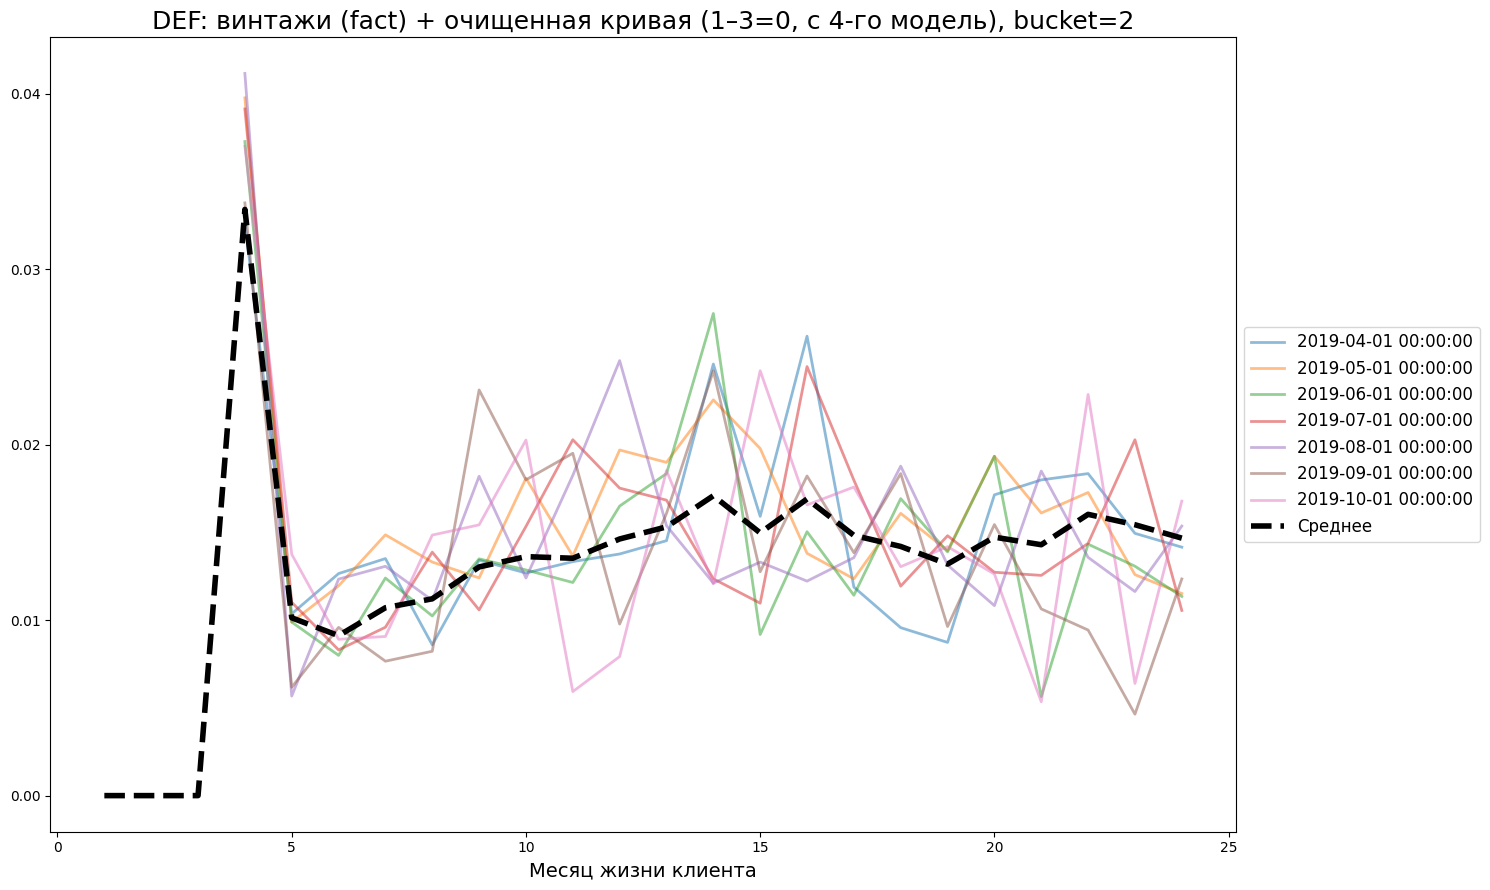

In [26]:
# средняя очищенная линия с 4-го
def_rate_mean = (
    res_def["fitted_data"]
    .query("statement_num >= 4")
    .groupby(["pd_bucket", "statement_num"], as_index=True)
    .agg(Среднее=("p_no_macro", "mean"))
)

def plot_def_rate_mean(pd_bucket):
    dfb = res_def["fitted_data"].copy()
    dfb["gen_month_dt"] = pd.to_datetime(dfb["gen_month_dt"])

    # исключили поколения
    dfb = dfb.loc[~dfb["gen_month_dt"].isin(exclude_gens)]
    dfb = dfb.query("pd_bucket == @pd_bucket")

    # винтажи: оставим >=4, а 1–3 дорисуем нулями
    dfb4 = dfb.query("statement_num >= 4")

    vint = (dfb4.groupby(["gen_month_dt", "statement_num"], as_index=False)
              .agg(def_rate=("def_rate_fact", "mean"))
              .pivot(index="statement_num", columns="gen_month_dt", values="def_rate"))

    ax = vint.plot(figsize=(15, 9), grid=True, lw=2, alpha=0.5)

    # чёрная линия: возьмём mean >=4 и дорисуем 1–3 нулями
    mean_line = def_rate_mean.loc[pd_bucket, "Среднее"].copy()

    pad = pd.Series({1: 0.0, 2: 0.0, 3: 0.0}, name="Среднее")
    mean_line2 = pd.concat([pad, mean_line]).sort_index()

    mean_line2.plot(ax=ax, lw=4, color="black", ls="dashed")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
    plt.title(f"DEF: винтажи (fact) + очищенная кривая (1–3=0, с 4-го модель), bucket={pd_bucket}", size=18)
    plt.xlabel("Месяц жизни клиента", size=14)
    plt.tight_layout()
    plt.show()

for i in sorted(buckets):
    plot_def_rate_mean(i)


### Сглаживание средних кривых (0.5 баллов) 

Рассмотри несколько функций для сглаживания кривой (можешь взять готовые из семинара, либо реализовать свои).

In [27]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res["Линейная функция"] = df["Среднее"]  # Копируем средние значения
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], 1
    )  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)  # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, "Линейная функция"] = linear_coeff(
        np.arange(start, finish + 1)
    )  # Записываем приближение
    df_res.loc[finish + 1 :, "Линейная функция"] = linear_coeff(
        finish + 1
    )  # Продолжаем кривую константой
    return df_res


def polynom_approximation(df, start=1, finish=20, degree=1):
    df_res = pd.DataFrame(df)
    df_res["Полином"] = df["Среднее"]
    linear_coeff = np.polyfit(
        np.arange(start, finish + 1), df.loc[start:finish, "Среднее"], degree
    )  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, "Полином"] = linear_coeff(np.arange(start, finish + 1))
    df_res.loc[finish + 1 :, "Полином"] = linear_coeff(finish + 1)
    return df_res


def exponential_smoothing(df, start, finish, alpha):
    df_res = df.copy()

    y = df_res["Среднее"].to_numpy()

    # start у вас “в месяцах” (1..), а numpy/iloc — 0.., поэтому:
    start0 = start - 1

    result = list(y[:start])  # первые start значений копируем

    for t in range(start, len(y)):  # t = start..len-1
        result.append(alpha * y[t] + (1 - alpha) * result[-1])

    df_res["Скользящее среднее"] = result
    return df_res


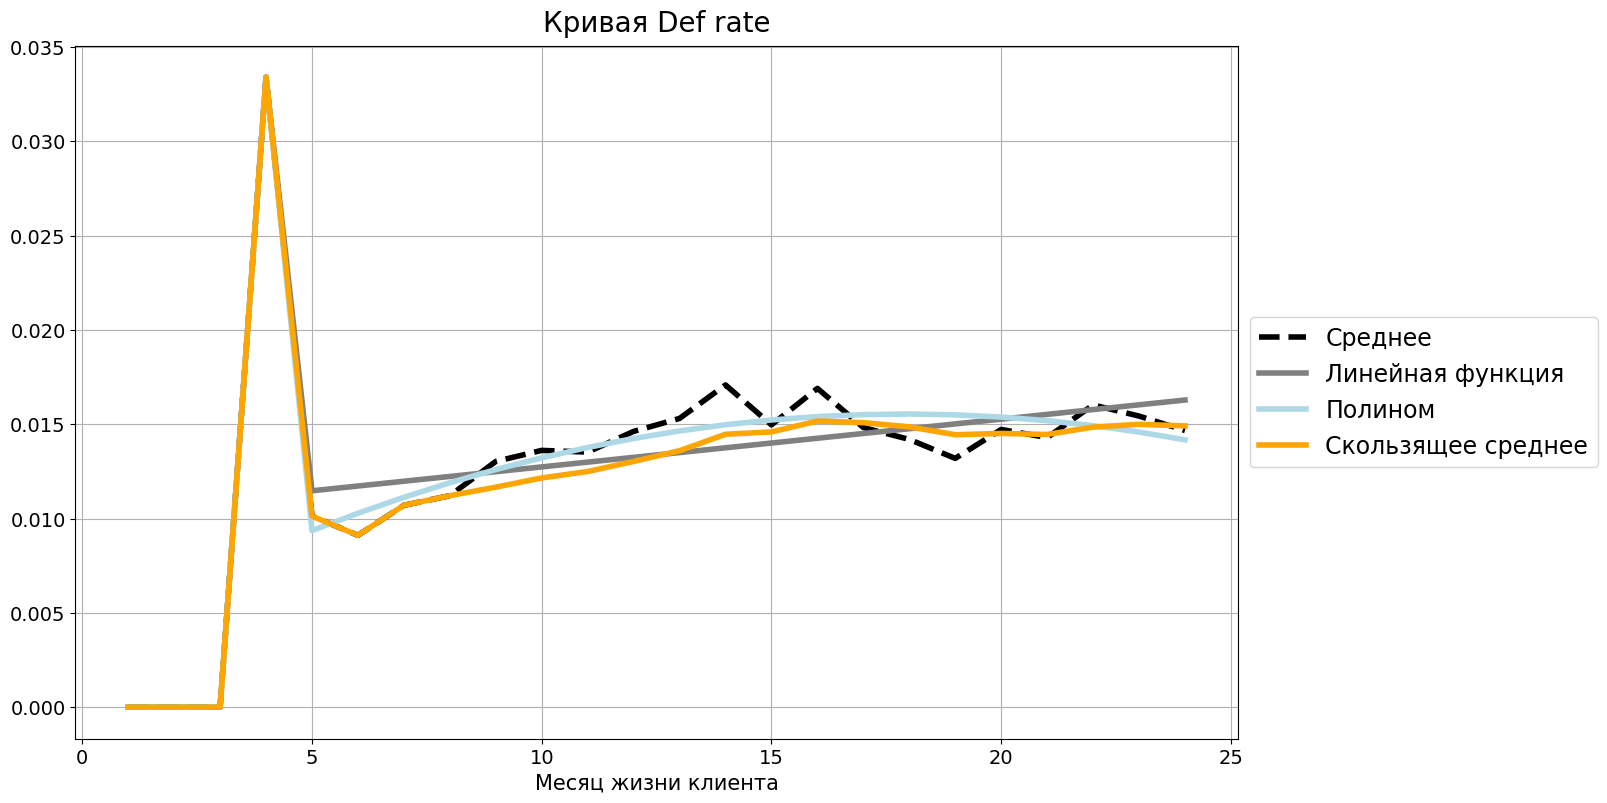

In [28]:
df_linear = (
    def_rate_mean.loc[2]   # bucket=2
    .reset_index()
    .set_index("statement_num")
)


df_linear = linear_approximation(df_linear, 5, 24)
df_polynom = polynom_approximation(df_linear, 5, 24, 2)
df_smooth = exponential_smoothing(df_polynom, 5, 24, 0.25)


pad_idx = pd.Index([1, 2, 3], name="statement_num")
pad = pd.DataFrame(index=pad_idx, columns=df_smooth.columns, data=0.0)

df_smooth = (
    pd.concat([pad, df_smooth], axis=0)
      .sort_index()
)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth["Среднее"].plot(grid=True, color="Black", linestyle="--", lw=4)
df_smooth["Линейная функция"].plot(grid=True, color="Gray", linestyle="-", lw=4)
df_smooth["Полином"].plot(grid=True, color="LightBlue", linestyle="-", lw=4)
df_smooth["Скользящее среднее"].plot(grid=True, color="Orange", linestyle="-", lw=4)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Кривая Def rate", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

In [29]:
print(df_polynom.index, df_polynom.index.min(), df_polynom.index.max())

RangeIndex(start=4, stop=25, step=1, name='statement_num') 4 24


#### Вывод: укажи выбранную функцию и обоснуй свой выбор. Были ли точки, к которым не применил(-a) сглаживание? Почему?

Полином лучше всего уловил зависимость. Точки 1-4 не сглаживал, иначе теряется фродовый пик. 

### Отрисуй сглаженные кривые по всем трем бакетам PD

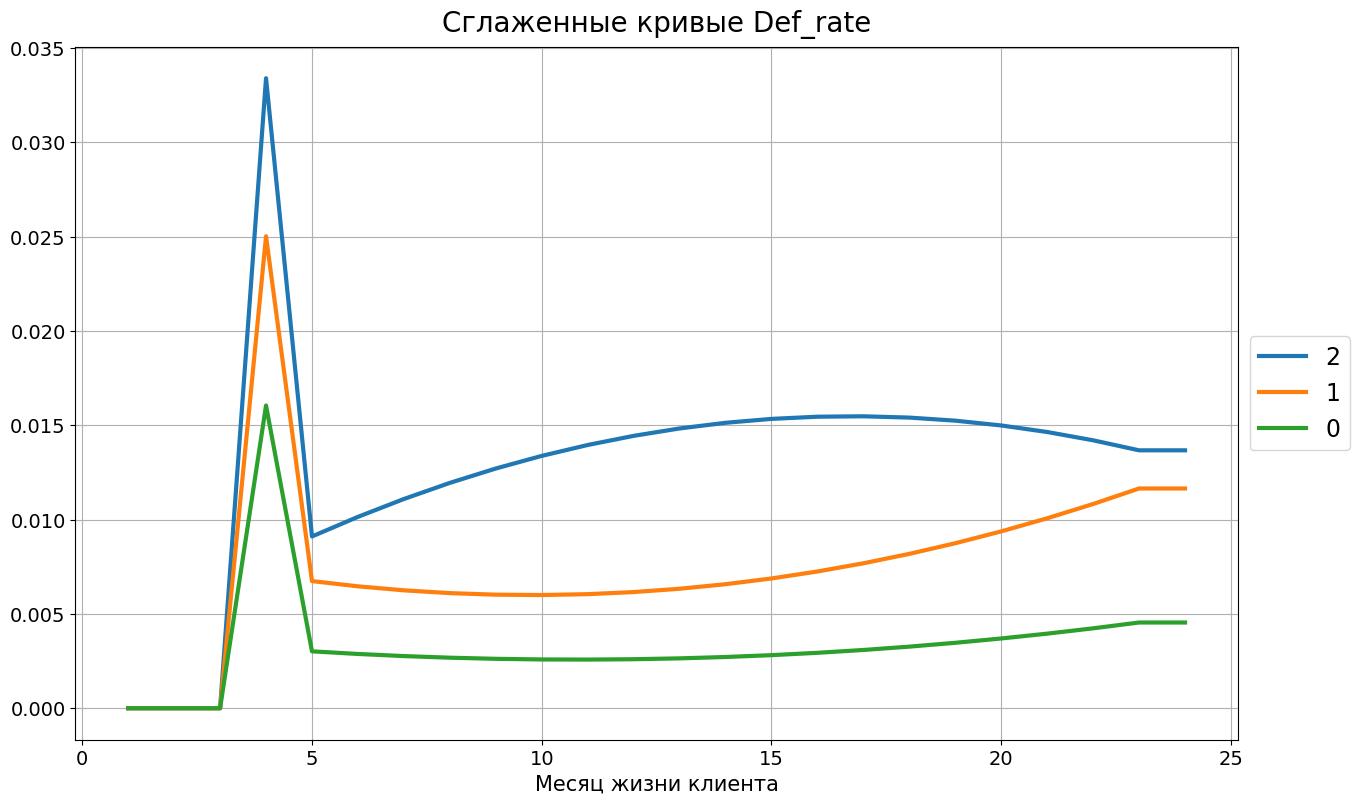

In [30]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in sorted(buckets, reverse=True):
    df_temp = (
        def_rate_mean.query("pd_bucket == " + str(bucket))
        .reset_index()
        .set_index(["statement_num"])
    )
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5, 22, 2)["Полином"]
pad_idx = pd.Index([1, 2, 3], name="statement_num")
pad = pd.DataFrame(index=pad_idx, columns=df_smooth_result.columns, data=0.0)

df_smooth_result = (
    pd.concat([pad, df_smooth_result], axis=0)
    .sort_index()
)

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw=3)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize="17")
plt.title("Сглаженные кривые Def_rate", size=20, verticalalignment="bottom")
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis="both", which="major", labelsize=14)

# Внедрение в NPV-модель

## Добавь в NPV-модель метод с расчетом DEF rate по твоей кривой

In [31]:
bucket_boundaries = data_scores.groupby('pd_bucket')['pd'].agg(['min', 'max']).reset_index()
print(bucket_boundaries)

   pd_bucket                   min                 max
0          0  0,000251831535869175  0,0207978253202053
1          1      0,02079833996393  0,0463160358407954
2          2    0,0463169414613166  0,0999972334888963


In [32]:
import numpy as np

class NPVModel:
    bucket_boundaries = data_scores.groupby('pd_bucket')['pd'].agg(['min', 'max']).reset_index()
    df_smooth_result = df_smooth_result
    
    avg_missed_payments = 1.5
    recovery = 0.50
    dlq_penalty_amount = 500
    oper_costs = 100
    collection_costs = 600
    tax_rate = 0.20
    discounting_rate = 0.30
    eq_req = 0.125
    cost_of_funds = 0.16
    dlq_ratio = np.ones(101)*0.20
    dlq_ratio[0] = 0
    shift = 4
    clo_rate = 1 / (np.arange(shift, shift + 101) ** 2)
    acquisition_cost = 1000
    ins_cost_rate = 0.005 #цена страховки от лимита 
    ins_cur = 0.4 # процент cur со страховкой
    ins_dlq = 0.6 # процент dlq со страховкой
    ins_prob = 0.001 # вероятность наступления стархового случая

    def __init__(self):
        pass

    def model_balance_calculations(self, amount, rate, term):
        '''
        Расчет модельных баланса, выплаченных процентов, регулярного платежа
        :param amount: Сумма кредита
        :param rate: Ставка
        :param term: Срок
        :return:
        balance : np.array(101) : остаток тела долга по кредиту на каждый месяц
        interest : np.array(101) : выплата по процентам каждый месяц
        regular_payment : float : размер регулярного платежа
        '''

        regular_payment = round(amount * (rate / 12) *\
                                (1 + (rate / 12)) / (1 - ((1 + rate / 12) ** (-term))))
        # График баланса и процентов
        balance = np.zeros(101)
        interest = np.zeros(101)
        balance[0] = amount

        for i in range(1, term + 1):
            int_payment = balance[i - 1] * rate / 12
            debt_payment = regular_payment - int_payment
            balance[i] = max(0, round(balance[i - 1] - debt_payment))
            interest[i] = int_payment
        return balance, interest, regular_payment

    def distribution_calc(self, portfolio_distribution, pd=None, pa=None):
        '''
        Расчет распределения по статусам
        :param portfolio_distribution: график распределения по статусам
        :return:
        cur_dist : np.array(101) : доля клиентов в статусе CUR на каждый месяц
        dlq_dist : np.array(101) : доля клиентов в статусе DLQ на каждый месяц
        act_dist : np.array(101) : доля клиентов в статусе ACT на каждый месяц
        def_dist : np.array(101) : доля клиентов в статусе DEF на каждый месяц
        clo_dist : np.array(101) : доля клиентов в статусе CLO на каждый месяц
        '''
        
        cur_dist = portfolio_distribution['CUR']
        dlq_dist = portfolio_distribution['DLQ']
        act_dist = cur_dist + dlq_dist
        def_dist = portfolio_distribution['DEF'] 
        clo_dist = portfolio_distribution['CLO']


        return cur_dist, dlq_dist, act_dist, def_dist, clo_dist

    def cur_balance_calc(self, model_balance, cur_dist):
        '''
        Расчет модельного баланса в статусе CUR
        :param model_balance: плановый график баланса
        :param cur_dist: доля клиентов в статусе CUR на каждый месяц
        :return:
        principal_balance_cur : np.array(101) : principal balance в статусе CUR
        gross_balance_cur : np.array(101) : gross balance в статусе CUR
        '''
        principal_balance_cur = model_balance*cur_dist
        gross_balance_cur = model_balance*cur_dist
        return principal_balance_cur, gross_balance_cur

    def dlq_balance_calc(self, model_balance, regular_payment, dlq_dist):
        '''
        Расчет модельного баланса в статусе DLQ
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_dlq : np.array(101) : principal balance в статусе DLQ
        gross_balance_dlq : np.array(101) : gross balance в статусе DLQ
        '''
        principal_balance_dlq = np.append(0, model_balance[:-1])*dlq_dist
        gross_balance_dlq = (model_balance + regular_payment*self.avg_missed_payments)*dlq_dist
        return principal_balance_dlq, gross_balance_dlq

    def act_balance_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq):
        '''
        Расчет модельного баланса в статусе ACT
        :param principal_balance_cur: principal balance в статусе CUR
        :param principal_balance_dlq: principal balance в статусе DLQ
        :param gross_balance_cur: principal balance в статусе CUR
        :param gross_balance_dlq: principal balance в статусе DLQ
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        principal_balance_act : np.array(101) : principal balance в статусе ACT
        gross_balance_act : np.array(101) : gross balance в статусе ACT
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq
        gross_balance_act = gross_balance_cur + gross_balance_dlq
        return principal_balance_act, gross_balance_act

    def def_balance_calc(self, model_balance, regular_payment, def_dist):
        '''
        Расчет модельного баланса в статусе DEF
        :param model_balance: плановый график баланса
        :param regular_payment: размер регулярного платежа
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        principal_balance_def : np.array(101) : principal balance в статусе DEF
        gross_balance_def : np.array(101) : gross balance в статусе DEF
        '''
        principal_balance_def = np.zeros(101)
        gross_balance_def = np.zeros(101)

        def_dist_change = def_dist[4:] - def_dist[3:-1]
        principal_balance_def[4:] = np.cumsum(model_balance[:-4] * def_dist_change)
        gross_balance_def[4:] = np.cumsum((model_balance[4:] + 4 * regular_payment) * def_dist_change)

        return principal_balance_def, gross_balance_def

    def profit_calc(self, principal_balance_cur, principal_balance_dlq, principal_balance_def, term, rate, dlq_dist):
        '''

        :param principal_balance_act: principal balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param rate: тавка по кредиту
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :return:
        profit : np.array(101) : доход на каждый месяц
        '''
        principal_balance_act = principal_balance_cur + principal_balance_dlq # тут поменял и в передаче

        interest_profit = principal_balance_act*rate/12
        penatly_profit = dlq_dist*self.dlq_penalty_amount

        new_def_balance = np.append(principal_balance_def[1:], 0) - principal_balance_def
        recovery_profit = new_def_balance*self.recovery



        insurance_limit_cur = principal_balance_dlq[0] * self.ins_dlq #
        insurance_limit_dlq = principal_balance_cur[0] * self.ins_cur #

        insurance_profit_monthly = np.zeros(101)
        insurance_profit_monthly[:term+1] = (insurance_limit_cur + insurance_limit_dlq) * self.ins_cost_rate

        profit = interest_profit + recovery_profit + penatly_profit + insurance_profit_monthly#
        profit[term+1:] = 0

        return profit

    def loss_calc(self, principal_balance_cur, principal_balance_dlq, gross_balance_act, principal_balance_def, term, act_dist, dlq_dist, def_dist):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :param principal_balance_def: principal balance в статусе DEF
        :param term: срок кредита
        :param act_dist: доля клиентов в статусе ACT на каждый месяц
        :param dlq_dist: доля клиентов в статусе DLQ на каждый месяц
        :param def_dist: доля клиентов в статусе DEF на каждый месяц
        :return:
        loss : np.array(101) : лосс на каждый месяц
        '''

        oper_loss = np.append(act_dist[1:], 0)*self.oper_costs
        loan_loss =  principal_balance_def - np.append(0, principal_balance_def[:-1])
        collection_loss = (np.append(dlq_dist[1:], 0) + np.append(def_dist[1:], 0))*self.collection_costs
        
        insurance_loss = np.zeros(101)
        insurance_limit_cur = principal_balance_dlq[0] * self.ins_cur
        insurance_limit_dlq = principal_balance_cur[0] * self.ins_dlq
        for t in range(1, term + 1):
                # Вероятность, что страховой случай произойдет именно в месяц t
                # (не произошел в предыдущие месяцы) × вероятность в текущем месяце
                prob_in_month_t = self.ins_prob * ((1 - self.ins_prob) ** (t - 1))
                
                # Ожидаемая выплата в месяц t
                insurance_loss[t] = (
                    insurance_limit_cur * prob_in_month_t +
                    insurance_limit_dlq * prob_in_month_t
                )
        

        prev_gross_balance_act = np.append(gross_balance_act[0], gross_balance_act[:-1]) 
        cost_of_funds_loss = prev_gross_balance_act*(1 - self.eq_req)*self.cost_of_funds/12

        loss = loan_loss + cost_of_funds_loss + oper_loss + collection_loss + insurance_loss
        loss[term+1:] = 0

        return loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss, insurance_loss

    def assets_liabilities_calc(self, gross_balance_act, insurance_loss):
        '''

        :param gross_balance_act: gross balance в статусе ACT
        :return:
        assets : np.array(101) : активы в проекте
        eq_req_curve : np.array(101) : активы, обеспеченные капиталом
        fund_req_curve : np.array(101) : активы, обеспеченные фондами
        '''

        # assets
        assets = gross_balance_act - insurance_loss 

        #liabilities
        eq_req_curve = assets*self.eq_req
        fund_req_curve = assets*(1 - self.eq_req)

        return assets, eq_req_curve, fund_req_curve

    def niat_calc(self, profit, loss):
        '''
        Расчет NIAT
        :param profit: суммарный доход на каждый месяц
        :param loss: суммарный лосс на каждый месяц
        :return:
        nibt : np.array(101) : прибыль до налогообложения
        niat : np.array(101) : прибыль после налогообложения
        tax : np.array(101) : налог в каждом месяце
        '''

        nibt = profit - loss
        tax = nibt*self.tax_rate
        niat = nibt - tax

        return nibt, niat, tax

    def cashflow_calc(self, principal_balance_act, principal_balance_def, amount, profit,
                      cost_of_funds_loss, oper_costs, collection_costs, tax, niat, eq_req_curve, fund_req_curve):
        '''
        Расчет денежных потоков
        :param principal_balance_act: principal balance в статусе DEF
        :param principal_balance_def: principal balance в статусе DEF
        :param amount: срок кредита
        :param profit: доход на каждый месяц
        :param cost_of_funds_loss: лоссы на фондирование
        :param oper_costs: операционные расходы
        :param collection_costs: расходы на коллекшн
        :param tax: налог в каждом месяце
        :param niat: доход после налогообложения
        :param eq_req_curve: активы, обеспеченные капиталом
        :param fund_req_curve: активы, обеспеченные фондами
        :return:
        cf_to_client : np.array(101) : денежный поток к клиенту
        cf_to_shareholders : np.array(101) : денежный поток к акционерам
        cf_to_debtholders : np.array(101) : денежный поток к фондам
        cf_to_cost_and_tax : np.array(101) : денежный поток на косты и налоги
        '''
        # client
        delta_principal_balance_act = (np.append(0, principal_balance_act[:100]) - principal_balance_act)
        delta_principal_balance_def = (np.append(0, principal_balance_def[:100]) - principal_balance_def)
        repayments = delta_principal_balance_act - delta_principal_balance_def + profit
        cf_to_client = np.append(amount, -repayments[1:])

        # debtoholder
        fund_req_ch = fund_req_curve - np.append(fund_req_curve[0], fund_req_curve[:-1])
        fund_req_change = np.append(fund_req_curve[0], fund_req_ch[1:])
        cf_to_debtholders = cost_of_funds_loss - fund_req_change

        # shareholders
        eq_req_ch = eq_req_curve - np.append(eq_req_curve[0], eq_req_curve[:-1])
        cf_to_shareholders = niat - np.append(eq_req_curve[0], eq_req_ch[1:])

        # cost and tax
        cf_to_cost_and_tax = oper_costs + collection_costs + tax

        return cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax

    def npv_calc(self, amount, rate, term, pd=None):
        '''
        Расчет NPV
        :param amount: сумма кредита
        :param rate: ставка по кредиту
        :param term: срок кредита
        :param portfolio_distribution: график распределения по статусам
        :param pd: вероятность дефолта к 12-ому месяцу
        :param pa: вероятность полного досрочного погашения к 6-ому месяцу
        :return: npv: чистая приведенная стоимость кредита
        '''

         # Считаем балансы
        model_balance, interest, regular_payment = self.model_balance_calculations(amount, rate, term)
        
        # Рассчитываем распределение по статусам
        cur_dist = np.zeros(101)
        dlq_dist = np.zeros(101)
        def_dist = np.zeros(101)
        clo_dist = np.zeros(101)
        act_dist = np.zeros(101)
        
        # В начале все клиенты в статусе CUR
        act_dist[0] = 1
        cur_dist[0] = 1
        
        self.def_rate = self.def_rate_calc(pd)
        
        for i in range(1, term + 1):
            clo_dist[i] = clo_dist[i - 1] + (self.clo_rate[i] * act_dist[i - 1])
            def_dist[i] = def_dist[i - 1] + (self.def_rate[i-1] * act_dist[i - 1])
            act_dist[i] = 1 - clo_dist[i] - def_dist[i]
            dlq_dist[i] = self.dlq_ratio[i] * act_dist[i]
            cur_dist[i] = act_dist[i] - dlq_dist[i]
            

        portfolio_distribution = {
            'CUR': cur_dist,
            'DLQ': dlq_dist,
            'DEF': def_dist,
            'CLO': clo_dist
        }

        # Считаем распределение
        cur_dist, dlq_dist, act_dist, def_dist, clo_dist = self.distribution_calc(portfolio_distribution)

        # Считаем балансы
        principal_balance_cur, gross_balance_cur = self.cur_balance_calc(model_balance, cur_dist)
        principal_balance_dlq, gross_balance_dlq = self.dlq_balance_calc(model_balance, regular_payment, dlq_dist)
        principal_balance_act, gross_balance_act = self.act_balance_calc(principal_balance_cur, principal_balance_dlq, gross_balance_cur, gross_balance_dlq)
        principal_balance_def, gross_balance_def = self.def_balance_calc(model_balance, regular_payment, def_dist)

        # Считаем профиты
        profit = self.profit_calc(principal_balance_cur, principal_balance_dlq, principal_balance_def, term, rate, dlq_dist)
        loss, loan_loss, cost_of_funds_loss, oper_loss, collection_loss, insurance_loss = self.loss_calc(principal_balance_cur, principal_balance_dlq, gross_balance_act, principal_balance_def,
                                                                                                                  term, act_dist, dlq_dist, def_dist)
        nibt, niat, tax = self.niat_calc(profit, loss)

        # Считаем активы и денежные потоки
        assets, eq_req_curve, fund_req_curve = self.assets_liabilities_calc(gross_balance_act, insurance_loss)
        cf_to_client, cf_to_shareholders, cf_to_debtholders, cf_to_cost_and_tax =\
            self.cashflow_calc(principal_balance_act, principal_balance_def, amount, profit, cost_of_funds_loss, oper_loss, collection_loss,
                               tax, niat, eq_req_curve, fund_req_curve)

        # Считаем NPV
        disc_curve = np.array([1 / ((1 + self.discounting_rate) ** (i / 12.)) for i in range(101)])
        pv = np.round(np.sum(disc_curve * cf_to_shareholders)).astype(int)
        npv = pv - self.acquisition_cost

        return npv
    
    def def_rate_calc(self, pd):
        bucket = None
        for _, row in self.bucket_boundaries.iterrows():
            min_value = float(row['min'].replace(',', '.'))
            max_value = float(row['max'].replace(',', '.'))
            if min_value <= pd <= max_value:
                bucket = row['pd_bucket']
                break
        if bucket is None:
            raise ValueError(f"Значение pd {pd} не попадает в ни один из заданных диапазонов.")

        # Выбираем кривую дефолта в зависимости от бакета
        if bucket == 0:
            return self.df_smooth_result['0'].to_numpy()
        elif bucket == 1:
            return self.df_smooth_result['1'].to_numpy()
        elif bucket == 2:
            return self.df_smooth_result['2'].to_numpy()
        else:
            return None

## Посчитай NPV по кредиту с параметрами

- Срок кредита 2 года
- Годовая процентная ставка 21%
- Сумма кредита 1 млн
- Страховка подключена

In [33]:
# тут для старой модели делал

'''def def_dist_from_curve(def_rate_curve, term, clo_dist=None, dlq_dist = None):
    T=101
    def_dist = np.zeros(T)
    cur_dist = np.zeros(T)

    if clo_dist is None:
        clo_dist = np.zeros(T)
    if dlq_dist is None:
        dlq_dist = np.zeros(T)

    cur_dist[0] = 1.0 - clo_dist[0] - dlq_dist[0] 
    for t in range(1, term+1):
        
        act_prev = 1 - def_dist[t-1] - clo_dist[t-1]
        h = float(def_rate_curve[t-1])
        def_dist[t] = def_dist[t-1] + act_prev * h

        cur_dist[t] = 1.0 - clo_dist[t] - dlq_dist[t] - def_dist[t]

    return def_dist, cur_dist
'''

'def def_dist_from_curve(def_rate_curve, term, clo_dist=None, dlq_dist = None):\n    T=101\n    def_dist = np.zeros(T)\n    cur_dist = np.zeros(T)\n\n    if clo_dist is None:\n        clo_dist = np.zeros(T)\n    if dlq_dist is None:\n        dlq_dist = np.zeros(T)\n\n    cur_dist[0] = 1.0 - clo_dist[0] - dlq_dist[0] \n    for t in range(1, term+1):\n\n        act_prev = 1 - def_dist[t-1] - clo_dist[t-1]\n        h = float(def_rate_curve[t-1])\n        def_dist[t] = def_dist[t-1] + act_prev * h\n\n        cur_dist[t] = 1.0 - clo_dist[t] - dlq_dist[t] - def_dist[t]\n\n    return def_dist, cur_dist\n'

In [34]:
import numpy as np
    

model = NPVModel()

npv_bucket_0 = model.npv_calc(amount=1_000_000, term=24, rate=0.21, pd= 0.00026)
npv_bucket_1 = model.npv_calc(amount=1_000_000, term=24, rate=0.21, pd=0.021)
npv_bucket_2 = model.npv_calc(amount=1_000_000, term=24, rate=0.21, pd=0.048)

print(f"NPV for Bucket 0: {npv_bucket_0}")
print(f"NPV for Bucket 1: {npv_bucket_1}")
print(f"NPV for Bucket 2: {npv_bucket_2}")

NPV for Bucket 0: 14355
NPV for Bucket 1: -2536
NPV for Bucket 2: -24323


## Построй график зависимости NPV от скора, которым ты побил(-а) DEF rate

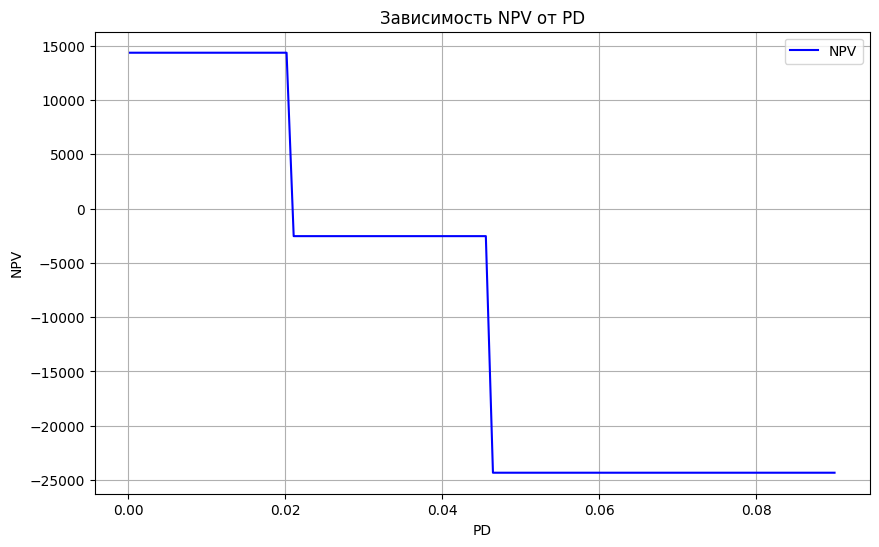

In [35]:
pd_values = np.linspace(0.00026, 0.09, 100)

def calculate_npv_for_pd(model, amount, term, rate, pd_values):
    npv_values = []
    for pd in pd_values:
        
        npv = model.npv_calc(amount=amount, term=term, rate=rate, pd=pd)
        npv_values.append(npv)
    return npv_values

amount = 1_000_000
term = 24
rate = 0.21

npv_values = calculate_npv_for_pd(model, amount, term, rate, pd_values)

plt.figure(figsize=(10, 6))
plt.plot(pd_values, npv_values, label='NPV', color='b')
plt.title("Зависимость NPV от PD")
plt.xlabel("PD")
plt.ylabel("NPV")
plt.grid(True)
plt.legend()
plt.show()